# 'Data Science 4 Covid19': analysis of testing dataset

### UC Sistemas Inteligentes para a Bioinformática 20 | 21

Group 4: 
> Carina Afonso PG40952 <br>
> Laura Duro PG40959 <br>
> Miguel Rocha PG40967 <br> 
> Miguel Martins PG40969 <br>

## 1. Work contextualization and data description

The Covid19 pandemic has been widely studied across several fields due to its large scale effects globally. More than 1.5 million people have died due to health complications caused by SARS-CoV-2 infection, since the final months of 2019. 

To figth this pandemic countries have been deploying different aproaches, namely testing policies. In this effort, we propose to analyse and explore the official testing data available for different countries. We aim to relate this information (tests wise) with other variables (demographic descriptors and pandemic related information) trough computacional methods such as machine and deep learning.

The data chosen for this work was retrieved from 'Our World in Data': https://ourworldindata.org/coronavirus-testing [1]. It comprises of a time series, updated around twice a week, with mostly numeric data from official sources from 111 countries, from which we aim to predict events or future tendencies.

## 2. Data preprocessing

### 2.1. Imports

#### 2.1.1. Libraries required

In [240]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm
import seaborn as sns
import sklearn as skl

#### 2.1.2. Data import

In [241]:
#import dataset - covid-19 testing data
data_imported = pd.read_csv('owid-covid-data.csv')

### 2.2. Inicial data screening

In [242]:
print('Shape:\t', data_imported.shape, '\n')
print('Columns:', data_imported.columns.values, '\n')

Shape:	 (59745, 55) 

Columns: ['iso_code' 'continent' 'location' 'date' 'total_cases' 'new_cases'
 'new_cases_smoothed' 'total_deaths' 'new_deaths' 'new_deaths_smoothed'
 'total_cases_per_million' 'new_cases_per_million'
 'new_cases_smoothed_per_million' 'total_deaths_per_million'
 'new_deaths_per_million' 'new_deaths_smoothed_per_million'
 'reproduction_rate' 'icu_patients' 'icu_patients_per_million'
 'hosp_patients' 'hosp_patients_per_million' 'weekly_icu_admissions'
 'weekly_icu_admissions_per_million' 'weekly_hosp_admissions'
 'weekly_hosp_admissions_per_million' 'new_tests' 'total_tests'
 'total_tests_per_thousand' 'new_tests_per_thousand' 'new_tests_smoothed'
 'new_tests_smoothed_per_thousand' 'positive_rate' 'tests_per_case'
 'tests_units' 'total_vaccinations' 'new_vaccinations'
 'new_vaccinations_smoothed' 'total_vaccinations_per_hundred'
 'new_vaccinations_smoothed_per_million' 'stringency_index' 'population'
 'population_density' 'median_age' 'aged_65_older' 'aged_70_older'


Trough the analysis of the presented variables in the dataset, we decided to remove the ones that presented no interest to the proposed task (testing analysis).

In [243]:
#drop columns with no interest
data_imported.columns
data_imported = data_imported.drop(columns = ['cardiovasc_death_rate', 
                                              'diabetes_prevalence', 
                                              'female_smokers',
                                              'male_smokers',
                                              'total_vaccinations',
                                              'total_vaccinations_per_hundred',
                                              'new_vaccinations',
                                              'new_vaccinations_smoothed', 
                                              'total_vaccinations_per_hundred',
                                              'new_vaccinations_smoothed_per_million'])

print('Shape:\t', data_imported.shape, '\n')

Shape:	 (59745, 46) 



In [244]:
#type of data per variable of interest
data_imported.dtypes

iso_code                               object
continent                              object
location                               object
date                                   object
total_cases                           float64
new_cases                             float64
new_cases_smoothed                    float64
total_deaths                          float64
new_deaths                            float64
new_deaths_smoothed                   float64
total_cases_per_million               float64
new_cases_per_million                 float64
new_cases_smoothed_per_million        float64
total_deaths_per_million              float64
new_deaths_per_million                float64
new_deaths_smoothed_per_million       float64
reproduction_rate                     float64
icu_patients                          float64
icu_patients_per_million              float64
hosp_patients                         float64
hosp_patients_per_million             float64
weekly_icu_admissions             

#### 2.2.1. Tests_units (variable)

Different countries might have different methods of registering data and/or reported their data in different formats.

In [245]:
#see test units
print('Number of entries per test type:')
print(data_imported.groupby(['tests_units']).size(), '\n\n')

#frequency table per countries
freq_table = pd.crosstab(index = data_imported['tests_units'], columns = data_imported['iso_code'])
print('Entries distribution per countries:\n')
print(freq_table, '\n\n')
print('Number of countries per test type:')
print((freq_table/freq_table).sum(axis = 1), '\n')
print('Total of countries:', ((freq_table/freq_table).sum(axis = 1)).sum(), '\n\n')

#check for missing values
null = data_imported.iloc[:, 33].isnull().sum()
na = data_imported.iloc[:, 33].isna().sum()
print('Missing values')
print('Null:', null, '\tNaN:', na, '\n')

Number of entries per test type:
tests_units
people tested       6944
samples tested      5292
tests performed    19531
units unclear        665
dtype: int64 


Entries distribution per countries:

iso_code         ARE  ARG  AUS  AUT  BEL  BGD  BGR  BHR  BIH  BLR  BOL  BRA  \
tests_units                                                                   
people tested      0  373    0    0    0    0    0    0    0    0    0    0   
samples tested     0    0    0    0    0    0    0    0    0    0    0    0   
tests performed  350    0  297  286  317  316  277    0  275  266  304   97   
units unclear      0    0    0    0    0    0    0  314    0    0    0    0   

iso_code         CAN  CHE  CHL  CHN  CIV  COD  COL  CPV  CRI  CUB  CYP  CZE  \
tests_units                                                                   
people tested    308    0    0    0    0    0    0    0  219    0    0    0   
samples tested     0    0    0    0  273  279    0    0    0    0    0    0   
tests perfo

After seeing how countries are distributed based on the tests_units variable we decided to use only data from dataset entries which reported the number of tests and not the number of people tested. We also decided to discard dataset entries without defined units.

We also checked for missing values (wich in this case correspond to null values).

Since the data was also registered at an Internacional and Worldlide level in this dataset, we decided to discard these entries as they compreend an compilation of data from several crountries.

In [246]:
#drop Nan
data_imported = data_imported.dropna(subset = ['tests_units'])

print('Missing values')
na = data_imported.iloc[:, 33].isna().sum()
print('NaN:', na, '\n\n')


#drop countries with odd units
countries_discard = pd.concat(objs = (freq_table.loc['units unclear'][freq_table.loc['units unclear'][:] != 0], 
                                      freq_table.loc['people tested'][freq_table.loc['people tested'][:] != 0]))
countries_discard.keys()

#discard internacional data
index_discard = np.concatenate([data_imported['location'][data_imported['location'] == 'International'].keys().values,
                                data_imported['location'][data_imported['location'] == 'World'].keys().values])
#discard countries without standardized testing
for code in countries_discard.keys().values:
    index_discard = np.concatenate([index_discard,
                                    data_imported['iso_code'][data_imported['iso_code'] == code].keys().values])

screened_data = data_imported.drop(index = index_discard)
    
#frequency table per countries
freq_table = pd.crosstab(index = screened_data['tests_units'], columns = screened_data['iso_code'])
print('Number of countries per test type:')
print((freq_table/freq_table).sum(axis = 1), '\n')
print('Total of countries:', ((freq_table/freq_table).sum(axis = 1)).sum(), '\n\n')

Missing values
NaN: 0 


Number of countries per test type:
tests_units
samples tested     19.0
tests performed    70.0
dtype: float64 

Total of countries: 89.0 




In total, 88 countries reported testing data in a similar way and further analysis will be conducted for these countries (we will be considering the number of tests performed / samples tested, not the number of people tested).

#### 2.2.2. Other testing variables

In [247]:
#NaN 
#screened_data['total_cases']

print('Null:')
null = screened_data.iloc[:, 4:31].isnull().sum()
print(null, '\n')
print('Total:\t', null.sum(), '\n\n')
print('NaN:')
na = screened_data.iloc[:, 4:31].isna().sum()
print(na, '\n')
print('Total:\t', na.sum(), '\n\n')

screened_data[['new_cases', 'new_cases_smoothed', 'new_deaths', 'new_deaths_smoothed', 'new_cases_per_million', 
'new_cases_smoothed_per_million', 'new_deaths_per_million', 'new_deaths_smoothed_per_million', 'icu_patients', 
'icu_patients_per_million', 'hosp_patients', 'hosp_patients_per_million', 'weekly_icu_admissions', 
'weekly_icu_admissions_per_million', 'weekly_hosp_admissions', 'weekly_hosp_admissions_per_million', 'new_tests', 
'new_tests_per_thousand', 'new_tests_smoothed', 'new_tests_smoothed_per_thousand']] = screened_data[['new_cases', 
'new_cases_smoothed', 'new_deaths', 'new_deaths_smoothed', 'new_cases_per_million', 'new_cases_smoothed_per_million', 
'new_deaths_per_million', 'new_deaths_smoothed_per_million', 'icu_patients', 'icu_patients_per_million', 
'hosp_patients', 'hosp_patients_per_million', 'weekly_icu_admissions', 'weekly_icu_admissions_per_million', 
'weekly_hosp_admissions', 'weekly_hosp_admissions_per_million', 'new_tests', 'new_tests_per_thousand', 
'new_tests_smoothed', 'new_tests_smoothed_per_thousand']].fillna(0)

print('NaN:')
na = screened_data.iloc[:, 4:31].isna().sum()
print(na, '\n')
print('Total:\t', na.sum(), '\n\n')

Null:
total_cases                             347
new_cases                               349
new_cases_smoothed                      495
total_deaths                           1639
new_deaths                             1639
new_deaths_smoothed                     495
total_cases_per_million                 347
new_cases_per_million                   349
new_cases_smoothed_per_million          495
total_deaths_per_million               1639
new_deaths_per_million                 1639
new_deaths_smoothed_per_million         495
reproduction_rate                      2820
icu_patients                          19939
icu_patients_per_million              19939
hosp_patients                         19807
hosp_patients_per_million             19807
weekly_icu_admissions                 24421
weekly_icu_admissions_per_million     24421
weekly_hosp_admissions                24126
weekly_hosp_admissions_per_million    24126
new_tests                              3876
total_tests               

Substitution of missing values of these pandemic related variables with 0 (when reported as a missing value, in these variables, it means there was no information on that entry regarding that variable).

In [248]:
print('NaN:')
na = screened_data.iloc[:, 4:].isna().sum()
print(na, '\n')
print('Total:\t', na.sum(), '\n\n')

NaN:
total_cases                             347
new_cases                                 0
new_cases_smoothed                        0
total_deaths                           1639
new_deaths                                0
new_deaths_smoothed                       0
total_cases_per_million                 347
new_cases_per_million                     0
new_cases_smoothed_per_million            0
total_deaths_per_million               1639
new_deaths_per_million                    0
new_deaths_smoothed_per_million           0
reproduction_rate                      2820
icu_patients                              0
icu_patients_per_million                  0
hosp_patients                             0
hosp_patients_per_million                 0
weekly_icu_admissions                     0
weekly_icu_admissions_per_million         0
weekly_hosp_admissions                    0
weekly_hosp_admissions_per_million        0
new_tests                                 0
total_tests                

In [249]:
print('Shape:\n', screened_data.shape, '\n')

screened_data = screened_data.drop(columns = ['handwashing_facilities'])
screened_data = screened_data.dropna(axis = 0)

print('NaN:')
na = screened_data.iloc[:, 4:].isna().sum()
print(na, '\n')
print('Total:\t', na.sum(), '\n\n')

print('Shape:\n', screened_data.shape)

Shape:
 (24823, 46) 

NaN:
total_cases                           0
new_cases                             0
new_cases_smoothed                    0
total_deaths                          0
new_deaths                            0
new_deaths_smoothed                   0
total_cases_per_million               0
new_cases_per_million                 0
new_cases_smoothed_per_million        0
total_deaths_per_million              0
new_deaths_per_million                0
new_deaths_smoothed_per_million       0
reproduction_rate                     0
icu_patients                          0
icu_patients_per_million              0
hosp_patients                         0
hosp_patients_per_million             0
weekly_icu_admissions                 0
weekly_icu_admissions_per_million     0
weekly_hosp_admissions                0
weekly_hosp_admissions_per_million    0
new_tests                             0
total_tests                           0
total_tests_per_thousand              0
new_tests_per

The 'total...' type of variables missing values could not be substituted with zero and therefore we decided to drop the corresponding entries.

The drop of the column 'handwashing_facilities' was due to lack of information regarding a considerable amount of countries (over 14 000 entries).

To deal with the other missing values, intead of dropping the columns in question we decided to drop the entries. In theses cases, we could not replace missing values with 0 because these variables do not represent counts but demographic indicators with their own scale and values associated.

In [250]:
 screened_data['iso_code'].unique().size

57

Further filtering of the data reduced the number of countries to a total of 57.

### 2.3. Statistical Analysis



In [251]:
screened_data.describe()

,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,new_deaths_per_million,new_deaths_smoothed_per_million,reproduction_rate,icu_patients,icu_patients_per_million,hosp_patients,hosp_patients_per_million,weekly_icu_admissions,weekly_icu_admissions_per_million,weekly_hosp_admissions,weekly_hosp_admissions_per_million,new_tests,total_tests,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,positive_rate,tests_per_case,stringency_index,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,hospital_beds_per_thousand,life_expectancy,human_development_index
count,1.340900e+04,13409.000000,13409.000000,13409.000000,13409.000000,13409.000000,13409.000000,13409.000000,13409.000000,13409.000000,13409.000000,13409.000000,13409.000000,13409.000000,13409.000000,13409.000000,13409.000000,13409.000000,13409.000000,13409.000000,13409.000000,1.340900e+04,1.340900e+04,13409.000000,13409.000000,1.340900e+04,13409.000000,13409.000000,13409.00000,13409.000000,1.340900e+04,13409.000000,13409.000000,13409.000000,13409.000000,13409.000000,13409.000000,13409.000000,13409.000000,13409.000000
mean,2.367152e+05,2549.819823,2496.027625,6365.440898,52.633455,52.023872,6115.154542,76.832483,74.921924,163.711765,1.595406,1.550308,1.098717,111.350585,4.266803,837.976657,37.100355,6.353209,0.603715,66.626515,3.040863,3.790574e+04,3.751097e+06,126.939159,1.245429,3.825962e+04,1.243616,0.081670,140.67096,64.355331,6.234894e+07,170.613543,33.981759,11.697703,7.638035,22423.816502,7.416705,3.204193,75.426317,0.765121
std,9.129812e+05,9104.712004,8867.638128,18011.375927,154.230454,145.232085,9539.682889,156.796500,138.348112,255.602727,3.755527,2.975825,0.280451,714.391713,13.703979,4509.141584,115.755458,195.777538,16.944342,1057.955367,47.803841,1.317766e+05,1.425842e+07,244.454858,2.335059,1.313662e+05,2.173760,0.094201,547.40364,17.687228,1.973787e+08,263.240817,8.902450,6.392287,4.506795,18484.053052,15.257563,2.265572,6.104895,0.132696
min,1.010000e+02,-161.000000,0.143000,1.000000,-117.000000,-117.286000,0.177000,-95.122000,0.006000,0.003000,-10.095000,-2.509000,0.170000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-4.751000e+04,8.360000e+02,0.010000,-0.786000,0.000000e+00,0.000000,0.000000,1.60000,14.810000,3.412500e+05,3.202000,16.400000,2.168000,1.308000,1095.042000,0.100000,0.200000,61.040000,0.463000
25%,3.447000e+03,31.000000,38.714000,64.000000,0.000000,0.571000,424.260000,3.261000,3.750000,8.116000,0.000000,0.049000,0.940000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.663000e+03,1.399480e+05,10.061000,0.103000,1.978000e+03,0.118000,0.015000,8.50000,50.930000,6.486201e+06,42.729000,27.600000,5.989000,3.414000,7292.458000,0.200000,1.400000,72.060000,0.685000
50%,2.401400e+04,309.000000,311.000000,564.000000,5.000000,5.429000,1913.208000,18.434000,18.991000,42.233000,0.288000,0.338000,1.080000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.453000e+03,5.003470e+05,39.497000,0.459000,5.733000e+03,0.505000,0.044000,22.50000,65.740000,1.486293e+07,88.125000,35.400000,11.373000,6.938000,22267.037000,0.700000,2.800000,76.740000,0.798000
75%,1.454730e+05,1511.000000,1495.429000,3553.000000,31.000000,31.571000,7113.868000,80.569000,79.738000,191.111000,1.598000,1.598000,1.230000,0.000000,0.000000,5.000000,2.651000,0.000000,0.000000,0.000000,0.000000,1.944900e+04,1.846793e+06,142.989000,1.438000,2.055000e+04,1.480000,0.118000,68.00000,79.630000,5.088288e+07,205.859000,42.300000,18.571000,11.976000,30155.152000,4.500000,4.510000,80.900000,0.871000
max,1.904217e+07,227253.000000,216649.286000,332068.000000,4143.000000,2603.857000,74148.210000,3142.293000,1536.030000,1677.450000,141.865000,28.770000,4.960000,22373.000000,127.183000,117344.000000,1042.535000

Above there are descriptive analysis made for each of the selected variables.

Text(0, 0.5, 'Share of the Population (%)')

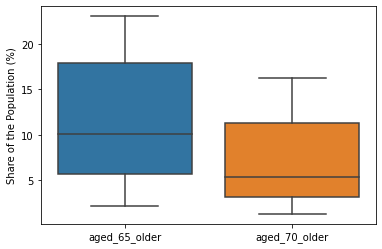

In [252]:
fig, axes = plt.subplots(1, 1, sharex = True)
sns.boxplot(data = screened_data[['iso_code', 'aged_65_older','aged_70_older']].drop_duplicates(subset=['iso_code']))
axes.set_ylabel('Share of the Population (%)')

In the figure above we can see the percentage of the population over 65 years old (yo) and over 70 yo. In some countries, the percentage reaches above 10% of the population which could be of importance considering that people in this age are considered part of the groups at risk.

Text(0, 0.5, 'Age (years)')

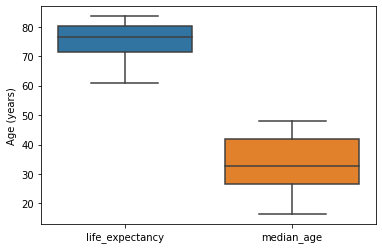

In [253]:
fig, axes = plt.subplots(1, 1, sharex = True)
sns.boxplot(data = screened_data[['iso_code', 'life_expectancy', 'median_age']].drop_duplicates(subset=['iso_code']))
axes.set_ylabel('Age (years)')

Regarding 'life_expectancy', as seen in the figure above, there's an interval between the ages of 70 and 80 which comprises around 50% of the countries' life expectancy values.
The median age for the 55 countries considered shows that possibly all types of countries (under developped, in development and developed) are present - median age is one of the development indicators. [2-3]

Text(0, 0.5, 'HDI')

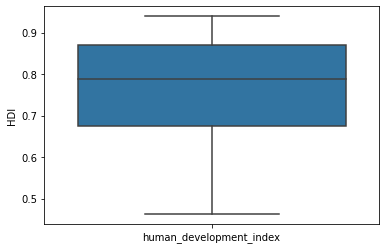

In [254]:
fig, axes = plt.subplots(1, 1, sharex = True)
sns.boxplot(data = screened_data[['iso_code', 'human_development_index']].drop_duplicates(subset=['iso_code']))
axes.set_ylabel('HDI')

According to the 'Human Development Report 2020: Reader's Guide', by United Nations Development Programme, 'HDI classifications are based on HDI fixed cutoff points, which are derived from the quartiles of dis- tributions of the component indicators. The cutoff-points are HDI of less than 0.550 for low human development, 0.550–0.699 for medium human development, 0.700–0.799 for high human development and 0.800 or greater for very high human development.'

In the figure above we can perceive that about 25% of the countries considered low to medium human development.

Text(0, 0.5, 'Positive rate')

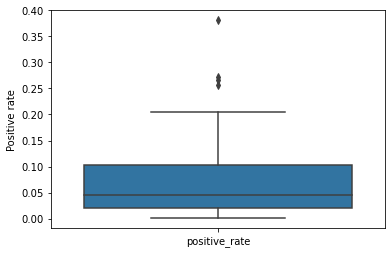

In [255]:
fig, axes = plt.subplots(1, 1, sharex = True)
sns.boxplot(data = screened_data[['iso_code','positive_rate']].drop_duplicates(subset=['iso_code']))
axes.set_ylabel('Positive rate')

The positive rates (ratio between positive tests and tests performed), for 50% of the countries selected, is below 5%. There are some countries who present an alarming value for positve rates.

### 2.4. Time series dataset preparation

Since we are working with time series it is necessary to index the date.

In [256]:
print('Type of data for date information:')
print(screened_data['date'].dtypes)
screened_data['date'] = pd.to_datetime(screened_data['date']) 
print('\nType of data for date information after conversion:')
print(screened_data['date'].dtypes)
print('\nShape of dataset:')
print(screened_data.shape)
screened_data = screened_data.set_index('date')
print('\nShape of dataset after indexing:')
print(screened_data.shape)

Type of data for date information:
object

Type of data for date information after conversion:
datetime64[ns]

Shape of dataset:
(13409, 45)

Shape of dataset after indexing:
(13409, 44)


#### 2.4.1. Dataset normalization

We aim to construct machine learning and deep learning models and it is beneficial to only use normalized data. We will also be using the normalized dataset for unsupervised machine learning annalysis.

In [257]:
screened_data.columns

Index(['iso_code', 'continent', 'location', 'total_cases', 'new_cases',
       'new_cases_smoothed', 'total_deaths', 'new_deaths',
       'new_deaths_smoothed', 'total_cases_per_million',
       'new_cases_per_million', 'new_cases_smoothed_per_million',
       'total_deaths_per_million', 'new_deaths_per_million',
       'new_deaths_smoothed_per_million', 'reproduction_rate', 'icu_patients',
       'icu_patients_per_million', 'hosp_patients',
       'hosp_patients_per_million', 'weekly_icu_admissions',
       'weekly_icu_admissions_per_million', 'weekly_hosp_admissions',
       'weekly_hosp_admissions_per_million', 'new_tests', 'total_tests',
       'total_tests_per_thousand', 'new_tests_per_thousand',
       'new_tests_smoothed', 'new_tests_smoothed_per_thousand',
       'positive_rate', 'tests_per_case', 'tests_units', 'stringency_index',
       'population', 'population_density', 'median_age', 'aged_65_older',
       'aged_70_older', 'gdp_per_capita', 'extreme_poverty',
       'hospi

In [258]:
normalize_data = screened_data[['iso_code', 'continent', 'location', 'total_cases_per_million', 
                                'new_cases_smoothed_per_million', 'total_deaths_per_million', 
                                'new_deaths_smoothed_per_million', 'reproduction_rate', 'icu_patients_per_million', 
                                'hosp_patients_per_million', 'weekly_icu_admissions_per_million', 
                                'weekly_hosp_admissions_per_million', 'total_tests_per_thousand', 
                                'new_tests_smoothed_per_thousand', 'positive_rate', 'tests_per_case', 
                                'stringency_index', 'population_density', 'median_age', 'aged_65_older', 
                                'aged_70_older', 'gdp_per_capita', 'extreme_poverty', 'hospital_beds_per_thousand', 
                                'life_expectancy', 'human_development_index']]

##### 2.4.1.1. Differencing the dataset

The de-trending of the data allows for the emergence of the real tendencies of the data. Since we have a time series and some variables will be of incremental values, it is important to avoid identifying such variables as strictly incremental tendencies. Some variables are constant values (i.e. gdp per capita) for which de-trending wouldn't make sense.

In [259]:
normalize_data_diff = pd.DataFrame(columns = ['total_cases_per_million', 'new_cases_smoothed_per_million', 
                                              'total_deaths_per_million', 'new_deaths_smoothed_per_million',
                                              'icu_patients_per_million', 'hosp_patients_per_million', 
                                              'weekly_icu_admissions_per_million', 'weekly_hosp_admissions_per_million',
                                              'total_tests_per_thousand', 'new_tests_smoothed_per_thousand',
                                              'tests_per_case'])

for iso in normalize_data['iso_code'].unique():
    normalize_data[normalize_data['iso_code'] == iso].shape
    normalize_data_diff = pd.concat([normalize_data_diff, 
                                    (normalize_data.loc[normalize_data['iso_code'] == iso][['total_cases_per_million', 
                                                       'new_cases_smoothed_per_million', 'total_deaths_per_million', 
                                                       'new_deaths_smoothed_per_million', 'icu_patients_per_million', 
                                                       'hosp_patients_per_million', 'weekly_icu_admissions_per_million',
                                                       'weekly_hosp_admissions_per_million','total_tests_per_thousand',
                                                       'new_tests_smoothed_per_thousand', 'tests_per_case']].diff())])

normalize_data_diff[['iso_code', 'continent', 'location',
                     'reproduction_rate', 'positive_rate', 
                     'stringency_index', 'population_density', 
                     'median_age', 'aged_65_older', 'aged_70_older', 
                     'gdp_per_capita', 'extreme_poverty', 
                     'hospital_beds_per_thousand', 
                     'life_expectancy', 'human_development_index']] = normalize_data[['iso_code', 'continent', 
                                                                                      'location',
                                                                                      'reproduction_rate', 
                                                                                      'positive_rate', 
                                                                                      'stringency_index', 
                                                                                      'population_density', 
                                                                                      'median_age', 'aged_65_older', 
                                                                                      'aged_70_older', 'gdp_per_capita',
                                                                                      'extreme_poverty', 
                                                                                      'hospital_beds_per_thousand', 
                                                                                      'life_expectancy', 
                                                                                      'human_development_index']]
    

normalize_data_diff = normalize_data_diff.dropna(axis = 0)

## 3. Unsupervised Machine Learning

### 3.1. Principal Component Analysis (PCA) 

#### 3.1.1. Data preparation

In [260]:
pca_data = normalize_data[['total_cases_per_million', 'new_cases_smoothed_per_million', 'total_deaths_per_million', 
                           'new_deaths_smoothed_per_million', 'reproduction_rate', 'icu_patients_per_million', 
                           'hosp_patients_per_million', 'weekly_icu_admissions_per_million', 
                           'weekly_hosp_admissions_per_million', 'total_tests_per_thousand', 'positive_rate', 
                           'tests_per_case', 'stringency_index', 'population_density', 'median_age', 'aged_65_older', 
                           'aged_70_older', 'gdp_per_capita', 'extreme_poverty', 'hospital_beds_per_thousand', 
                           'life_expectancy', 'human_development_index']]

For this analysis we choose the variables that we thought that could be relevant (i.e. we excluded variables related to the countries original data). 

Since we are analysing testing data we aim to predict the variable 'new_tests_smoothed_per_thousand'. We choose this variable because its value is representative in a ration fashion (value per thousand), making it comparable between countries, and it has already been cautioned the appearance of sudden spikes as a result of an update of testing data from weekend report.

In [261]:
data_diff_pca = normalize_data_diff

new_tests_diff = data_diff_pca['new_tests_smoothed_per_thousand']

data_diff_pca = data_diff_pca.drop(columns = ['new_tests_smoothed_per_thousand', 'iso_code', 'continent', 'location'])

We also will be performing PCA on the differenciated dataset.

Text(0, 0.5, 'Number of new tests smothed per thousand de-trended')

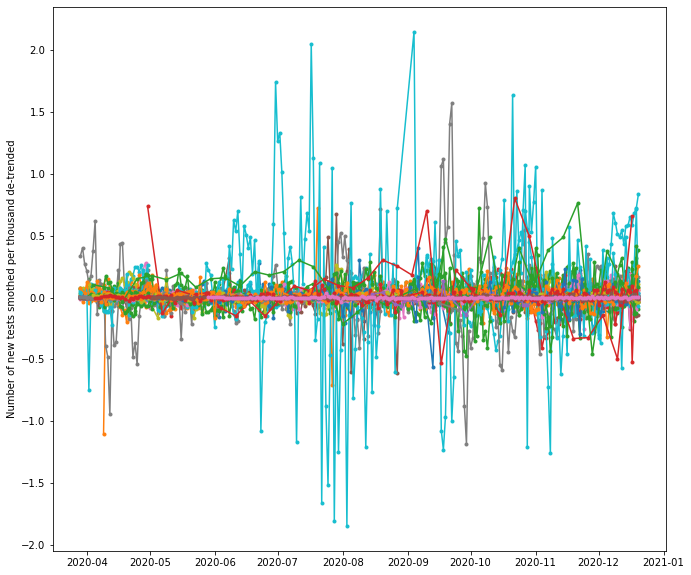

In [262]:
start, end = '2020-03-29', '2020-12-20'

fig, ax = plt.subplots(figsize=(11, 10))
for iso in normalize_data_diff['iso_code'].unique():
    plot_data = normalize_data_diff[normalize_data_diff['iso_code'] == iso]
    ax.plot(plot_data.loc[start:end, 'new_tests_smoothed_per_thousand'], marker='o', markersize = 3, linestyle='-', label='First Order Differencing')
ax.set_ylabel('Number of new tests smothed per thousand de-trended')
#ax.legend()

In the plot above each country has a different color attributed and it's represented the variability regarding the variable  'new_tests_smoothed_per_thousand'.

#### 3.1.2. PCA without de-trending

In [464]:
from sklearn.decomposition import PCA 

In [492]:
pca = PCA()
X_pca = pca.fit(pca_data)

Text(0, 0.5, 'cumulative explained variance')

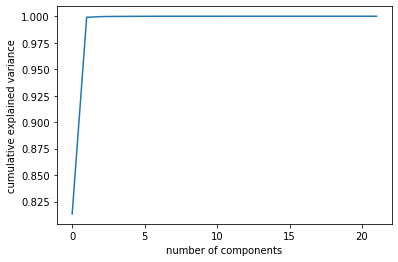

In [493]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

In the figure above, less than 5 principal components are needed to explain the variance in te dataset.

In [494]:
pca = PCA(n_components = 0.99)
X_pca = pca.fit_transform(pca_data)
print(pca.n_components_)

2


The PCA identified 2 Principal Components that account for the explanation of 99% of the variability found in the dataset.

In [495]:
num_components = 2
pca = PCA(num_components)  
X_pca = pca.fit_transform(pca_data) 

In [496]:
n_pcs = pca.n_components_ 
most_important = [np.abs(pca.components_[i]).argmax() for i in range(n_pcs)]
initial_feature_names = pca_data.columns

most_important_names = [initial_feature_names[most_important[i]] for i in range(n_pcs)]

In [497]:
most_important_names

['gdp_per_capita', 'total_cases_per_million']

The PCA identified 'gdp_per_capita' and 'total_cases_per_million' as the most explanatory of the variability observed.

In [498]:
pd.set_option("display.max_rows", None, "display.max_columns", None)
print(pd.DataFrame(pca.components_, columns = pca_data.columns))

   total_cases_per_million  new_cases_smoothed_per_million  \
0                 0.197929                        0.002566   
1                 0.979827                        0.009838   

   total_deaths_per_million  new_deaths_smoothed_per_million  \
0                  0.004461                         0.000035   
1                  0.019345                         0.000186   

   reproduction_rate  icu_patients_per_million  hosp_patients_per_million  \
0      -2.756026e-07                  0.000282                   0.001929   
1      -4.749167e-06                  0.000472                   0.004274   

   weekly_icu_admissions_per_million  weekly_hosp_admissions_per_million  \
0                           0.000041                            0.000087   
1                           0.000193                            0.000268   

   total_tests_per_thousand  positive_rate  tests_per_case  stringency_index  \
0                  0.008098      -0.000001        0.002016         -0.000179   

The table above demonstrates the weights that each variable has on each component. The 'gdp_per_capita' is the most influential in the first component and 'total_cases_per_million' is the most influential on the second component. In the second component, the 'gdp_per_capita' has a negative influence.

##### 3.1.2.1. PCA plots

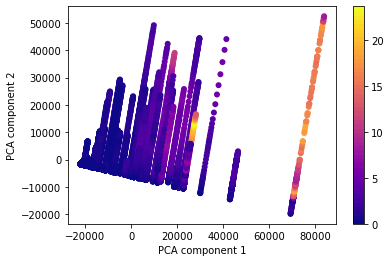

In [499]:
plt.scatter(X_pca[:, 0], X_pca[:, 1],
            c = normalize_data['new_tests_smoothed_per_thousand'], edgecolor='none', 
            cmap = plt.cm.get_cmap('plasma', 50))
plt.xlabel('PCA component 1')
plt.ylabel('PCA component 2')
plt.colorbar();

The plot above doesn't demostrate a clear separation between the data, althought we can perceive an increase in testing when the values of each component increment. Furthermore, it is noticeable along the increase of the values of the Principal Component 1 (majorly ruled by the 'gdp_per_capita' variable) that the corresponding value of the Principal Component 2 (majorly ruled by the 'total_cases_per_million' variable) decreases. This means that a higher value of 'gdp_per_capita' is associated with a higher number of testing and a smaller ratio of total cases per tests.

#### 3.1.3. PCA with de-trending

In [473]:
pca = PCA()
X_pca = pca.fit(data_diff_pca)

Text(0, 0.5, 'cumulative explained variance')

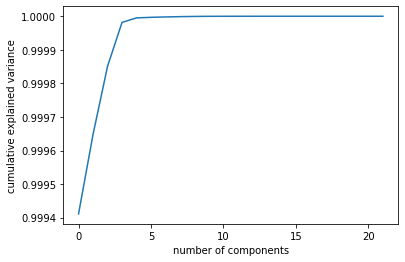

In [474]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

In the figure above, less than 5 principal components are needed to explain the variance in te dataset.

In [475]:
pca = PCA(n_components = 0.99)
X_pca = pca.fit_transform(data_diff_pca)
print(pca.n_components_)

1


In [476]:
n_pcs = pca.n_components_ 
most_important = [np.abs(pca.components_[i]).argmax() for i in range(n_pcs)]
initial_feature_names = pca_data.columns

most_important_names = [initial_feature_names[most_important[i]] for i in range(n_pcs)]

In [477]:
most_important_names

['gdp_per_capita']

The PCA identified 'gdp_per_capita' as the most explanatory of the variability observed.

In [478]:
print(pd.DataFrame(pca.components_, columns = data_diff_pca.columns))

   total_cases_per_million  new_cases_smoothed_per_million  \
0                 0.002549                        0.000019   

   total_deaths_per_million  new_deaths_smoothed_per_million  \
0                  0.000034                     2.851663e-07   

   icu_patients_per_million  hosp_patients_per_million  \
0                  0.000002                   0.000013   

   weekly_icu_admissions_per_million  weekly_hosp_admissions_per_million  \
0                       7.820570e-10                       -2.637788e-09   

   total_tests_per_thousand  tests_per_case  reproduction_rate  positive_rate  \
0                  0.000082        0.000017      -1.107133e-07      -0.000001   

   stringency_index  population_density  median_age  aged_65_older  \
0         -0.000191            0.000174    0.000301       0.000215   

   aged_70_older  gdp_per_capita  extreme_poverty  hospital_beds_per_thousand  \
0       0.000149        0.999997        -0.000386                    0.000053   

   life_e

The table above demonstrates the weights that each variable has on the component. The 'gdp_per_capita' is the most influential.

##### 3.1.3.1. PCA plots

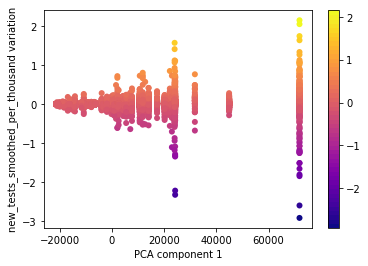

In [491]:
plt.scatter(X_pca[:, 0], new_tests_diff,
            c = normalize_data_diff['new_tests_smoothed_per_thousand'], edgecolor='none',
            cmap = plt.cm.get_cmap('plasma', 50))
plt.xlabel('PCA component 1')
plt.ylabel('new_tests_smoothed_per_thousand variation')
plt.colorbar();

In the plot above there isn't a clear separetion of the data, but it appears to be organized in vertical stripes since the Principal Component 1 is heavily influenced by 'gdp_per_capita'. Most likely the vertical stripes are composed by countries with similar gdp values. With the increase of the principal component value there is also an increase in the variation of the variable 'new_tests_smoothed_per_thousand'.

Text(0, 0.5, 'new_tests_smoothed_per_thousand variation')

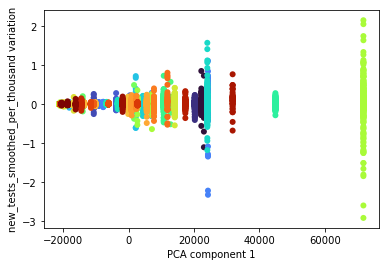

In [480]:
color_map = []
dic = {}

for i in range(normalize_data_diff['iso_code'].unique().size):
    dic[normalize_data_diff['iso_code'].unique()[i]] = i

for iso in normalize_data_diff['iso_code']:
    color_map.append(dic[iso])
    
plt.scatter(X_pca[:, 0], new_tests_diff,
            c = color_map, edgecolor='none', cmap = plt.cm.get_cmap('turbo', 50))
plt.xlabel('PCA component 1')
plt.ylabel('new_tests_smoothed_per_thousand variation')

Coloring the same plot by country confirmed our previous analysis: each vertical stripe represents a different country.

### 3.2. Hierarchical Clustering Dendrogram

#### 3.2.1.Data preparation

In [280]:
hierarc_data = normalize_data[['continent', 'location', 'total_cases_per_million', 'new_cases_smoothed_per_million',
                               'total_deaths_per_million', 'new_deaths_smoothed_per_million', 'reproduction_rate',
                               'icu_patients_per_million', 'hosp_patients_per_million',
                               'weekly_icu_admissions_per_million', 'weekly_hosp_admissions_per_million',
                               'total_tests_per_thousand', 'new_tests_smoothed_per_thousand', 'positive_rate',
                               'tests_per_case', 'stringency_index', 'population_density', 'median_age',
                               'aged_65_older', 'aged_70_older', 'gdp_per_capita', 'extreme_poverty',
                               'hospital_beds_per_thousand', 'life_expectancy', 'human_development_index']]

In [281]:
last_day_hierarc_data = pd.DataFrame(columns = ['continent', 'location', 'total_cases_per_million',
                                                'new_cases_smoothed_per_million',
                               'total_deaths_per_million', 'new_deaths_smoothed_per_million', 'reproduction_rate',
                               'icu_patients_per_million', 'hosp_patients_per_million',
                               'weekly_icu_admissions_per_million', 'weekly_hosp_admissions_per_million',
                               'total_tests_per_thousand', 'new_tests_smoothed_per_thousand', 'positive_rate',
                               'tests_per_case', 'stringency_index', 'population_density', 'median_age',
                               'aged_65_older', 'aged_70_older', 'gdp_per_capita', 'extreme_poverty',
                               'hospital_beds_per_thousand', 'life_expectancy', 'human_development_index'])

for country in hierarc_data.location.unique():
    last_day_hierarc_data = last_day_hierarc_data.append(hierarc_data[hierarc_data.location == country].iloc[-1, :])

In [282]:
last_day_hierarc_data.head()

,continent,location,total_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,new_deaths_smoothed_per_million,reproduction_rate,icu_patients_per_million,hosp_patients_per_million,weekly_icu_admissions_per_million,weekly_hosp_admissions_per_million,total_tests_per_thousand,new_tests_smoothed_per_thousand,positive_rate,tests_per_case,stringency_index,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,hospital_beds_per_thousand,life_expectancy,human_development_index
2020-12-30,Oceania,Australia,1113.927,0.801,35.647,0.006,1.19,0.000,0.000,0.0,0.0,439.388,2.180,0.000,2721.2,68.06,3.202,37.9,15.504,10.129,44648.710,0.5,3.84,83.44,0.939
2020-12-30,Europe,Austria,39738.630,214.847,682.737,7.852,0.92,43.858,223.397,0.0,0.0,423.047,2.030,0.106,9.4,78.70,106.749,44.4,19.202,13.748,45436.686,0.7,7.37,81.54,0.908
2020-12-13,Asia,Bangladesh,2978.534,11.266,42.820,0.186,0.84,0.000,0.000,0.0,0.0,18.019,0.092,0.122,8.2,80.09,1265.036,27.5,5.098,3.262,3523.984,14.8,0.80,72.59,0.608
2020-12-30,Europe,Belgium,55587.864,146.942,1677.450,6.188,0.89,42.711,201.387,0.0,0.0,598.284,2.272,0.073,13.7,60.19,375.564,41.8,18.571,12.849,42658.576,0.2,5.64,81.63,0.916
2020-12-30,South America,Bolivia,13567.344,77.199,783.773,1.028,1.57,0.000,0.000,0.0,0.0,35.165,0.197,0.392,2.6,52.78,10.202,25.4,6.704,4.393,6885.829,7.1,1.10,71.51,0.693


#### 3.2.2. Construction of the clustering dendrogram 

In [283]:
import scipy.cluster.hierarchy as hac
# Do the clustering
Z = hac.linkage(last_day_hierarc_data.iloc[:, 2:], method = 'single', metric = 'correlation',
                optimal_ordering = True)

Z_av = hac.linkage(last_day_hierarc_data.iloc[:, 2:], method = 'average', metric = 'correlation',
                   optimal_ordering = True)

In [284]:
dic_color = {'Oceania': 'black',
             'Europe': 'tab:cyan',
             'Asia': 'tab:orange',
             'South America': 'tab:red',
             'North America': 'tab:green',
             'Africa': 'tab:purple'}

dic_color_country = {}
for country in hierarc_data.location.unique():
    continent = hierarc_data[hierarc_data.location == country].continent.unique()[0]
    dic_color_country[country] = dic_color[continent]

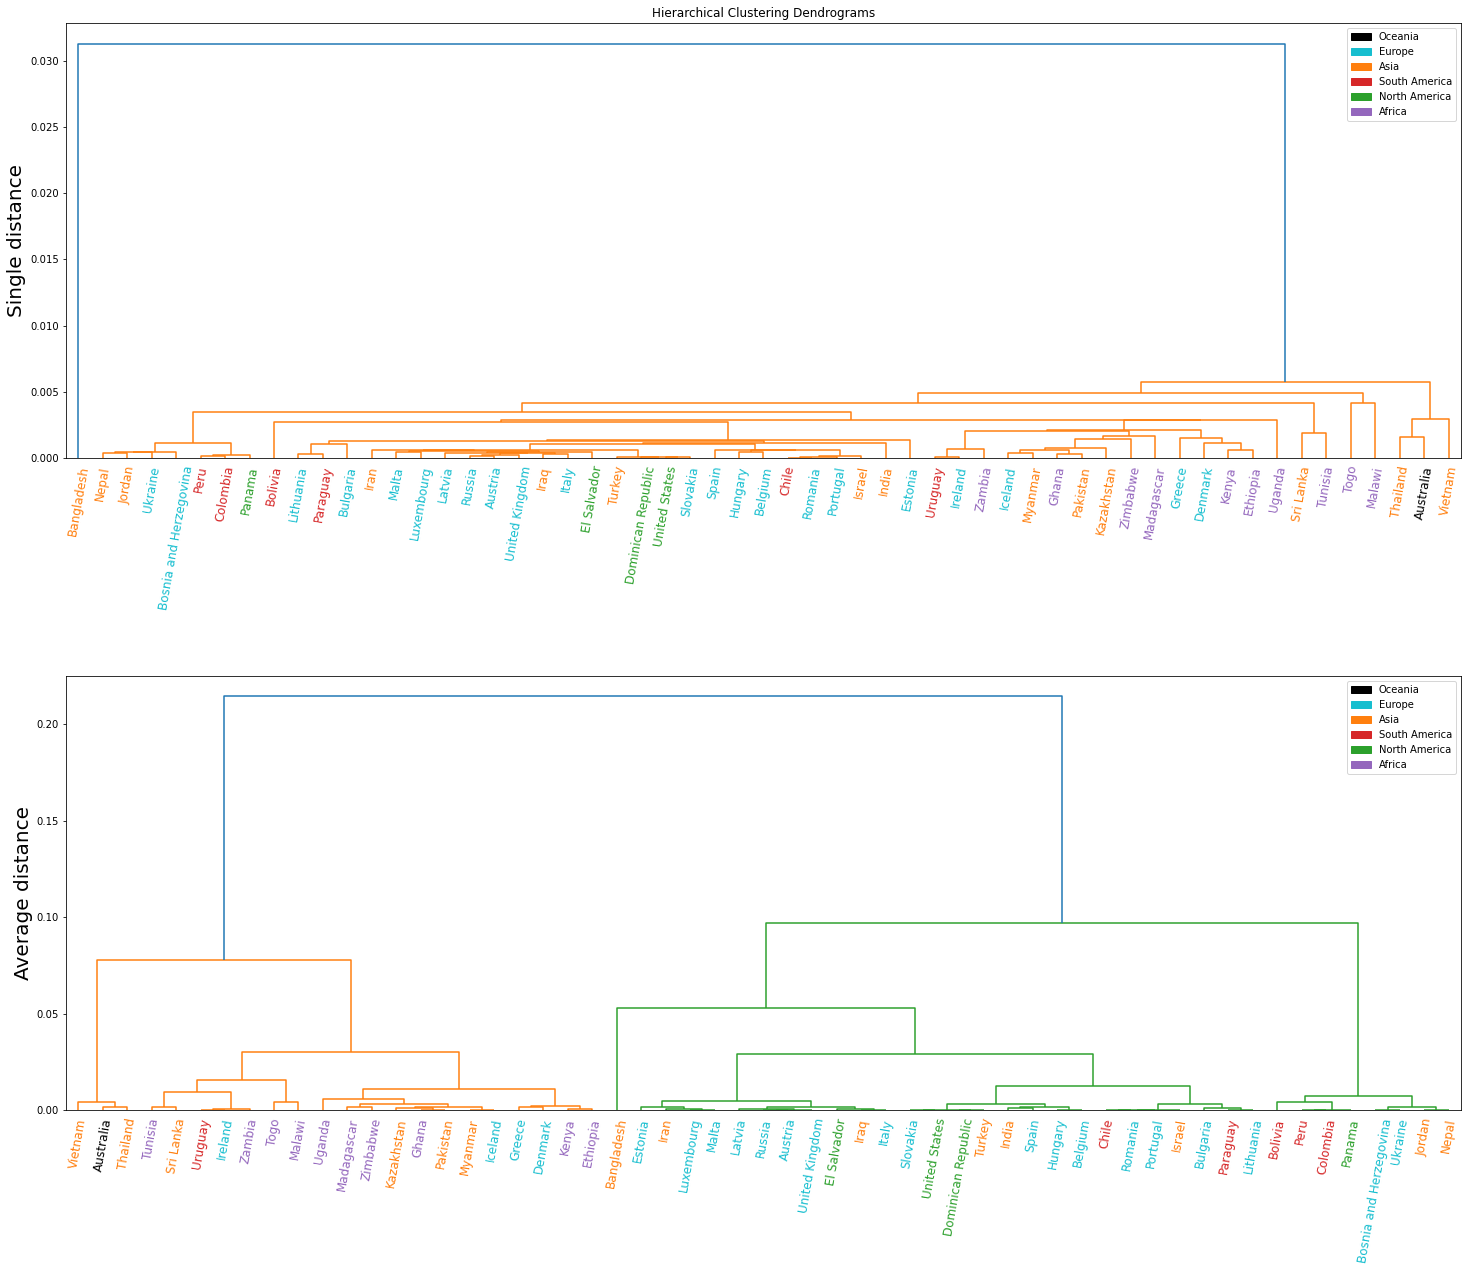

In [285]:
# Plot dendrogram
import matplotlib.patches as mpatches
fig, ax = plt.subplots(2, 1, figsize=(25, 20))
Z_dnd = hac.dendrogram(Z,
                       leaf_rotation=80.,
                       leaf_font_size=12.,  # font size for the x axis labels
                       orientation='top',
                       ax = ax[0],
                       labels = last_day_hierarc_data.location)
Z_av_dnd = hac.dendrogram(Z_av,
                          leaf_rotation=80.,  # rotates the x axis labels
                          leaf_font_size=12.,  # font size for the x axis labels
                          orientation='top',
                          ax = ax[1],
                          labels = last_day_hierarc_data.location)
ax[0].set_title('Hierarchical Clustering Dendrograms')
ax[0].set_ylabel('Single distance', fontsize = 20)
ax[1].set_ylabel('Average distance', fontsize = 20)
plt.subplots_adjust(hspace = 0.5)

Oceania = mpatches.Patch(color = dic_color['Oceania'], label = 'Oceania')
Europe = mpatches.Patch(color = dic_color['Europe'], label = 'Europe')
Asia = mpatches.Patch(color = dic_color['Asia'], label = 'Asia')
South_America = mpatches.Patch(color = dic_color['South America'], label = 'South America')
North_America = mpatches.Patch(color = dic_color['North America'], label = 'North America')
Africa = mpatches.Patch(color = dic_color['Africa'], label = 'Africa')

ax[0].legend(handles = [Oceania, Europe, Asia, South_America, North_America, Africa])
ax[1].legend(handles = [Oceania, Europe, Asia, South_America, North_America, Africa])

xlabels_Z = ax[0].get_xmajorticklabels()
xlabels_Z_av = ax[1].get_xmajorticklabels()

for x_labels in (xlabels_Z, xlabels_Z_av):
    for labels in x_labels:
        labels.set_color(dic_color_country[labels.get_text()])
        
plt.show()

In [286]:
from scipy.cluster.hierarchy import fcluster

def print_clusters(hierarc_data, Z, k, plot=False):
    # k Number of clusters we'd like to extract
    results = fcluster(Z, k, criterion='maxclust')
    # check the results
    s = pd.Series(results)
    clusters = s.unique()
    for c in clusters:
        cluster_indeces = s[s==c].index
        print("Cluster %d number of entries %d" % (c, len(cluster_indeces)))
        if plot:
            timeSeries.T.iloc[:,cluster_indeces].plot()
            plt.show()
            
print_clusters(hierarc_data, Z, 6, plot=False)

Cluster 5 number of entries 3
Cluster 1 number of entries 49
Cluster 6 number of entries 1
Cluster 4 number of entries 1
Cluster 2 number of entries 2
Cluster 3 number of entries 1


In [287]:
def print_clusters(hierarc_data, Z, k, plot=False):
    # k Number of clusters we'd like to extract
    results = fcluster(Z_av, k, criterion='maxclust')
    # check the results
    s = pd.Series(results)
    clusters = s.unique()
    for c in clusters:
        cluster_indeces = s[s==c].index
        print("Cluster %d number of entries %d" % (c, len(cluster_indeces)))
        if plot:
            timeSeries.T.iloc[:,cluster_indeces].plot()
            plt.show()
            
print_clusters(hierarc_data, Z, 6, plot=False)

Cluster 1 number of entries 3
Cluster 4 number of entries 26
Cluster 5 number of entries 1
Cluster 6 number of entries 8
Cluster 3 number of entries 12
Cluster 2 number of entries 7


## 4. Supervised Machine Learning

We aim the creation of a model capable of predicting the variable 'new_tests_smoothed_per_thousand'. 

### 4.1. Datasets Preparation

In [288]:
normalize_data['location'].unique()

array(['Australia', 'Austria', 'Bangladesh', 'Belgium', 'Bolivia',
       'Bosnia and Herzegovina', 'Bulgaria', 'Chile', 'Colombia',
       'Denmark', 'Dominican Republic', 'El Salvador', 'Estonia',
       'Ethiopia', 'Ghana', 'Greece', 'Hungary', 'Iceland', 'India',
       'Iran', 'Iraq', 'Ireland', 'Israel', 'Italy', 'Jordan',
       'Kazakhstan', 'Kenya', 'Latvia', 'Lithuania', 'Luxembourg',
       'Madagascar', 'Malawi', 'Malta', 'Myanmar', 'Nepal', 'Pakistan',
       'Panama', 'Paraguay', 'Peru', 'Portugal', 'Romania', 'Russia',
       'Slovakia', 'Spain', 'Sri Lanka', 'Thailand', 'Togo', 'Tunisia',
       'Turkey', 'Uganda', 'Ukraine', 'United Kingdom', 'United States',
       'Uruguay', 'Vietnam', 'Zambia', 'Zimbabwe'], dtype=object)

In [289]:
countries = []

for continent in normalize_data['continent'].unique():
    df = normalize_data[normalize_data['continent'] == continent]
    max_gdp = df['gdp_per_capita'].max()
    min_gdp = df['gdp_per_capita'].min()
    if max_gdp != min_gdp:
        countries.append(df[df['gdp_per_capita'] == max_gdp]['location'].unique()[0])
        countries.append(df[df['gdp_per_capita'] == min_gdp]['location'].unique()[0])
    else:
        countries.append(df[df['gdp_per_capita'] == max_gdp]['location'].unique()[0])
        
print(countries)

['Australia', 'Luxembourg', 'Ukraine', 'Israel', 'Nepal', 'Chile', 'Bolivia', 'United States', 'El Salvador', 'Tunisia', 'Malawi']


In order to select some countries to construct models, we decided to choose, for each continent, 2 countries (the one with the highest gdp_per_capita value and with the lowest value, since it was a variable identified in the 2 datasets used for PCA as the most influencial in the variability of the dataset.

In [290]:
normalize_data[normalize_data['continent'] == 'Oceania']['location'].unique()

array(['Australia'], dtype=object)

In the continent 'Oceania' there is only one country (originally there were more but they were excluded troughout the preprocessing and seletion of the dataset).

In [291]:
Australia = normalize_data[normalize_data['location'] == 'Australia']
Australia_diff = normalize_data_diff[normalize_data_diff['location'] == 'Australia']

Luxembourg = normalize_data[normalize_data['location'] == 'Luxembourg']
Luxembourg_diff = normalize_data_diff[normalize_data_diff['location'] == 'Luxembourg']

Ukraine = normalize_data[normalize_data['location'] == 'Ukraine']
Ukraine_diff = normalize_data_diff[normalize_data_diff['location'] == 'Ukraine']

Israel = normalize_data[normalize_data['location'] == 'Israel']
Israel_diff = normalize_data_diff[normalize_data_diff['location'] == 'Israel']

Nepal = normalize_data[normalize_data['location'] == 'Nepal']
Nepal_diff = normalize_data_diff[normalize_data_diff['location'] == 'Nepal']

Chile = normalize_data[normalize_data['location'] == 'Chile']
Chile_diff = normalize_data_diff[normalize_data_diff['location'] == 'Chile']

Bolivia = normalize_data[normalize_data['location'] == 'Bolivia']
Bolivia_diff = normalize_data_diff[normalize_data_diff['location'] == 'Bolivia']

USA = normalize_data[normalize_data['location'] == 'United States']
USA_diff = normalize_data_diff[normalize_data_diff['location'] == 'United States']

Salvador = normalize_data[normalize_data['location'] == 'El Salvador']
Salvador_diff = normalize_data_diff[normalize_data_diff['location'] == 'El Salvador']

Tunisia = normalize_data[normalize_data['location'] == 'Tunisia']
Tunisia_diff = normalize_data_diff[normalize_data_diff['location'] == 'Tunisia']

Malawi = normalize_data[normalize_data['location'] == 'Malawi']
Malawi_diff = normalize_data_diff[normalize_data_diff['location'] == 'Malawi']

We will construct 22 models, two for each countrie previously selected, one model for each dataset type.

#### 4.1.1. Australia

In [292]:
Australia.head()

,iso_code,continent,location,total_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,new_deaths_smoothed_per_million,reproduction_rate,icu_patients_per_million,hosp_patients_per_million,weekly_icu_admissions_per_million,weekly_hosp_admissions_per_million,total_tests_per_thousand,new_tests_smoothed_per_thousand,positive_rate,tests_per_case,stringency_index,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,hospital_beds_per_thousand,life_expectancy,human_development_index
date,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-03-29,AUS,Oceania,Australia,156.236,13.642,0.627,0.050,1.45,0.0,0.0,0.0,0.0,8.285,0.382,0.036,28.0,71.30,3.202,37.9,15.504,10.129,44648.71,0.5,3.84,83.44,0.939
2020-04-05,AUS,Oceania,Australia,223.021,9.541,1.373,0.106,0.77,0.0,0.0,0.0,0.0,11.653,0.481,0.020,50.4,73.15,3.202,37.9,15.504,10.129,44648.71,0.5,3.84,83.44,0.939
2020-04-06,AUS,Oceania,Australia,227.334,8.045,1.569,0.129,0.70,0.0,0.0,0.0,0.0,11.869,0.443,0.018,55.1,73.15,3.202,37.9,15.504,10.129,44648.71,0.5,3.84,83.44,0.939
2020-04-07,AUS,Oceania,Australia,231.178,7.485,1.765,0.151,0.65,0.0,0.0,0.0,0.0,12.184,0.420,0.018,56.1,73.15,3.202,37.9,15.504,10.129,44648.71,0.5,3.84,83.44,0.939
2020-04-08,AUS,Oceania,Australia,235.687,6.431,1.961,0.168,0.61,0.0,0.0,0.0,0.0,12.524,0.399,0.016,62.1,73.15,3.202,37.9,15.504,10.129,44648.71,0.5,3.84,83.44,0.939


In [293]:
Australia.columns

Index(['iso_code', 'continent', 'location', 'total_cases_per_million',
       'new_cases_smoothed_per_million', 'total_deaths_per_million',
       'new_deaths_smoothed_per_million', 'reproduction_rate',
       'icu_patients_per_million', 'hosp_patients_per_million',
       'weekly_icu_admissions_per_million',
       'weekly_hosp_admissions_per_million', 'total_tests_per_thousand',
       'new_tests_smoothed_per_thousand', 'positive_rate', 'tests_per_case',
       'stringency_index', 'population_density', 'median_age', 'aged_65_older',
       'aged_70_older', 'gdp_per_capita', 'extreme_poverty',
       'hospital_beds_per_thousand', 'life_expectancy',
       'human_development_index'],
      dtype='object')

In [294]:
tests_Australia = Australia['new_tests_smoothed_per_thousand']

Australia = Australia[['total_cases_per_million', 'new_cases_smoothed_per_million',
                       'new_deaths_smoothed_per_million', 'total_tests_per_thousand', 
                       'positive_rate', 'stringency_index','new_tests_smoothed_per_thousand']] # 'tests_per_case', 'reproduction_rate', 'total_deaths_per_million'

tests_Australia_diff = Australia_diff['new_tests_smoothed_per_thousand']

Australia_diff = Australia_diff[['total_cases_per_million', 'new_cases_smoothed_per_million', 
                                 'total_deaths_per_million', 'new_deaths_smoothed_per_million', 'reproduction_rate', 
                                 'total_tests_per_thousand', 'positive_rate', 'tests_per_case', 'stringency_index',
                                 'new_tests_smoothed_per_thousand']]

#### 4.1.2. Luxembourg

In [295]:
Luxembourg.head()

,iso_code,continent,location,total_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,new_deaths_smoothed_per_million,reproduction_rate,icu_patients_per_million,hosp_patients_per_million,weekly_icu_admissions_per_million,weekly_hosp_admissions_per_million,total_tests_per_thousand,new_tests_smoothed_per_thousand,positive_rate,tests_per_case,stringency_index,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,hospital_beds_per_thousand,life_expectancy,human_development_index
date,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-03-18,LUX,Europe,Luxembourg,324.294,44.730,3.195,0.456,2.25,0.000,0.000,0.0,0.0,3.824,0.521,0.086,11.6,79.63,231.447,39.7,14.312,9.842,94277.965,0.2,4.51,82.25,0.904
2020-03-19,LUX,Europe,Luxembourg,535.164,72.116,6.390,0.913,2.24,0.000,1.598,0.0,0.0,5.264,0.687,0.105,9.5,79.63,231.447,39.7,14.312,9.842,94277.965,0.2,4.51,82.25,0.904
2020-03-20,LUX,Europe,Luxembourg,773.193,102.697,6.390,0.913,2.18,4.793,33.548,0.0,0.0,6.853,0.872,0.118,8.5,79.63,231.447,39.7,14.312,9.842,94277.965,0.2,4.51,82.25,0.904
2020-03-21,LUX,Europe,Luxembourg,1070.329,141.265,12.780,1.598,2.11,9.585,99.045,0.0,0.0,7.553,0.952,0.148,6.7,79.63,231.447,39.7,14.312,9.842,94277.965,0.2,4.51,82.25,0.904
2020-03-22,LUX,Europe,Luxembourg,1274.809,168.651,12.780,1.598,2.01,3.195,103.838,0.0,0.0,7.587,0.952,0.177,5.6,79.63,231.447,39.7,14.312,9.842,94277.965,0.2,4.51,82.25,0.904


In [296]:
Luxembourg.columns

Index(['iso_code', 'continent', 'location', 'total_cases_per_million',
       'new_cases_smoothed_per_million', 'total_deaths_per_million',
       'new_deaths_smoothed_per_million', 'reproduction_rate',
       'icu_patients_per_million', 'hosp_patients_per_million',
       'weekly_icu_admissions_per_million',
       'weekly_hosp_admissions_per_million', 'total_tests_per_thousand',
       'new_tests_smoothed_per_thousand', 'positive_rate', 'tests_per_case',
       'stringency_index', 'population_density', 'median_age', 'aged_65_older',
       'aged_70_older', 'gdp_per_capita', 'extreme_poverty',
       'hospital_beds_per_thousand', 'life_expectancy',
       'human_development_index'],
      dtype='object')

In [297]:
tests_Luxembourg = Luxembourg['new_tests_smoothed_per_thousand']

Luxembourg = Luxembourg[['total_cases_per_million', 'new_cases_smoothed_per_million', 'total_deaths_per_million',
                         'new_deaths_smoothed_per_million', 'reproduction_rate', 'icu_patients_per_million', 
                         'hosp_patients_per_million', 'total_tests_per_thousand', 'positive_rate', 'tests_per_case', 
                         'stringency_index','new_tests_smoothed_per_thousand']]

tests_Luxembourg_diff = Luxembourg_diff['new_tests_smoothed_per_thousand']

Luxembourg_diff = Luxembourg_diff[['total_cases_per_million', 'new_cases_smoothed_per_million', 
                                   'total_deaths_per_million', 'new_deaths_smoothed_per_million', 'reproduction_rate', 
                                   'icu_patients_per_million', 'hosp_patients_per_million', 'total_tests_per_thousand',
                                   'positive_rate', 'tests_per_case', 'stringency_index','new_tests_smoothed_per_thousand']]

#### 4.1.3. Ukraine

In [298]:
Ukraine.head()

,iso_code,continent,location,total_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,new_deaths_smoothed_per_million,reproduction_rate,icu_patients_per_million,hosp_patients_per_million,weekly_icu_admissions_per_million,weekly_hosp_admissions_per_million,total_tests_per_thousand,new_tests_smoothed_per_thousand,positive_rate,tests_per_case,stringency_index,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,hospital_beds_per_thousand,life_expectancy,human_development_index
date,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-04-16,UKR,Europe,Ukraine,95.144,7.412,2.652,0.193,1.57,0.0,0.0,0.0,0.0,0.979,0.073,0.102,9.8,88.89,77.39,41.4,16.462,11.133,7894.393,0.1,8.8,72.06,0.751
2020-04-17,UKR,Europe,Ukraine,106.600,8.032,2.858,0.183,1.53,0.0,0.0,0.0,0.0,1.077,0.077,0.104,9.6,88.89,77.39,41.4,16.462,11.133,7894.393,0.1,8.8,72.06,0.751
2020-04-19,UKR,Europe,Ukraine,124.595,8.728,3.224,0.189,1.40,0.0,0.0,0.0,0.0,1.306,0.084,0.103,9.7,88.89,77.39,41.4,16.462,11.133,7894.393,0.1,8.8,72.06,0.751
2020-04-23,UKR,Europe,Ukraine,163.947,9.829,4.276,0.232,1.32,0.0,0.0,0.0,0.0,1.653,0.096,0.102,9.8,88.89,77.39,41.4,16.462,11.133,7894.393,0.1,8.8,72.06,0.751
2020-04-26,UKR,Europe,Ukraine,197.033,10.348,4.779,0.222,1.21,0.0,0.0,0.0,0.0,2.044,0.105,0.098,10.2,88.89,77.39,41.4,16.462,11.133,7894.393,0.1,8.8,72.06,0.751


In [299]:
Ukraine.columns

Index(['iso_code', 'continent', 'location', 'total_cases_per_million',
       'new_cases_smoothed_per_million', 'total_deaths_per_million',
       'new_deaths_smoothed_per_million', 'reproduction_rate',
       'icu_patients_per_million', 'hosp_patients_per_million',
       'weekly_icu_admissions_per_million',
       'weekly_hosp_admissions_per_million', 'total_tests_per_thousand',
       'new_tests_smoothed_per_thousand', 'positive_rate', 'tests_per_case',
       'stringency_index', 'population_density', 'median_age', 'aged_65_older',
       'aged_70_older', 'gdp_per_capita', 'extreme_poverty',
       'hospital_beds_per_thousand', 'life_expectancy',
       'human_development_index'],
      dtype='object')

In [300]:
tests_Ukraine = Ukraine['new_tests_smoothed_per_thousand']

Ukraine = Ukraine[['total_cases_per_million', 'new_cases_smoothed_per_million', 'total_deaths_per_million',
                   'new_deaths_smoothed_per_million', 'reproduction_rate', 'total_tests_per_thousand', 'positive_rate',
                   'tests_per_case', 'stringency_index','new_tests_smoothed_per_thousand']]

tests_Ukraine_diff = Ukraine_diff['new_tests_smoothed_per_thousand']

Ukraine_diff = Ukraine_diff[['total_cases_per_million', 'new_cases_smoothed_per_million',
                             'total_deaths_per_million', 'new_deaths_smoothed_per_million', 'reproduction_rate',
                             'total_tests_per_thousand', 'positive_rate', 'tests_per_case', 'stringency_index',
                             'new_tests_smoothed_per_thousand']]

#### 4.1.4. Israel

In [301]:
Israel.head()

,iso_code,continent,location,total_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,new_deaths_smoothed_per_million,reproduction_rate,icu_patients_per_million,hosp_patients_per_million,weekly_icu_admissions_per_million,weekly_hosp_admissions_per_million,total_tests_per_thousand,new_tests_smoothed_per_thousand,positive_rate,tests_per_case,stringency_index,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,hospital_beds_per_thousand,life_expectancy,human_development_index
date,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-03-20,ISR,Asia,Israel,72.555,8.516,0.116,0.017,2.82,0.0,0.0,0.0,0.0,2.003,0.186,0.046,21.9,81.48,402.606,30.6,11.733,7.359,33132.32,0.5,2.99,82.97,0.903
2020-03-21,ISR,Asia,Israel,97.394,11.636,0.116,0.017,2.79,0.0,0.0,0.0,0.0,2.246,0.211,0.055,18.1,81.48,402.606,30.6,11.733,7.359,33132.32,0.5,2.99,82.97,0.903
2020-03-22,ISR,Asia,Israel,124.776,14.904,0.116,0.017,2.73,0.0,0.0,0.0,0.0,2.633,0.247,0.060,16.6,81.48,402.606,30.6,11.733,7.359,33132.32,0.5,2.99,82.97,0.903
2020-03-23,ISR,Asia,Israel,144.301,16.472,0.116,0.017,2.68,0.0,0.0,0.0,0.0,3.052,0.284,0.058,17.3,81.48,402.606,30.6,11.733,7.359,33132.32,0.5,2.99,82.97,0.903
2020-03-24,ISR,Asia,Israel,156.085,17.429,0.462,0.066,2.67,0.0,0.0,0.0,0.0,3.605,0.336,0.052,19.3,81.48,402.606,30.6,11.733,7.359,33132.32,0.5,2.99,82.97,0.903


In [302]:
Israel.columns

Index(['iso_code', 'continent', 'location', 'total_cases_per_million',
       'new_cases_smoothed_per_million', 'total_deaths_per_million',
       'new_deaths_smoothed_per_million', 'reproduction_rate',
       'icu_patients_per_million', 'hosp_patients_per_million',
       'weekly_icu_admissions_per_million',
       'weekly_hosp_admissions_per_million', 'total_tests_per_thousand',
       'new_tests_smoothed_per_thousand', 'positive_rate', 'tests_per_case',
       'stringency_index', 'population_density', 'median_age', 'aged_65_older',
       'aged_70_older', 'gdp_per_capita', 'extreme_poverty',
       'hospital_beds_per_thousand', 'life_expectancy',
       'human_development_index'],
      dtype='object')

In [303]:
tests_Israel = Israel['new_tests_smoothed_per_thousand']

Israel = Israel[['total_cases_per_million', 'new_cases_smoothed_per_million', 'total_deaths_per_million',
                 'new_deaths_smoothed_per_million', 'reproduction_rate', 'total_tests_per_thousand', 'positive_rate',
                 'tests_per_case', 'stringency_index','new_tests_smoothed_per_thousand','new_tests_smoothed_per_thousand']]

tests_Israel_diff = Israel_diff['new_tests_smoothed_per_thousand']

Israel_diff = Israel_diff[['total_cases_per_million', 'new_cases_smoothed_per_million', 'total_deaths_per_million', 
                           'new_deaths_smoothed_per_million', 'reproduction_rate', 'total_tests_per_thousand', 
                           'positive_rate', 'tests_per_case', 'stringency_index','new_tests_smoothed_per_thousand']]

#### 4.1.5. Nepal

In [304]:
Nepal.head()

,iso_code,continent,location,total_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,new_deaths_smoothed_per_million,reproduction_rate,icu_patients_per_million,hosp_patients_per_million,weekly_icu_admissions_per_million,weekly_hosp_admissions_per_million,total_tests_per_thousand,new_tests_smoothed_per_thousand,positive_rate,tests_per_case,stringency_index,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,hospital_beds_per_thousand,life_expectancy,human_development_index
date,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-05-16,NPL,Asia,Nepal,9.987,0.887,0.034,0.005,1.78,0.0,0.0,0.0,0.0,0.916,0.051,0.017,57.4,92.59,204.43,25.0,5.809,3.212,2442.804,15.0,0.3,70.78,0.574
2020-05-17,NPL,Asia,Nepal,10.125,0.907,0.069,0.010,1.77,0.0,0.0,0.0,0.0,0.967,0.055,0.016,60.9,92.59,204.43,25.0,5.809,3.212,2442.804,15.0,0.3,70.78,0.574
2020-05-18,NPL,Asia,Nepal,12.870,1.182,0.069,0.010,1.80,0.0,0.0,0.0,0.0,1.054,0.063,0.019,53.6,92.59,204.43,25.0,5.809,3.212,2442.804,15.0,0.3,70.78,0.574
2020-05-19,NPL,Asia,Nepal,13.797,0.907,0.069,0.010,1.77,0.0,0.0,0.0,0.0,1.133,0.069,0.013,75.9,92.59,204.43,25.0,5.809,3.212,2442.804,15.0,0.3,70.78,0.574
2020-05-20,NPL,Asia,Nepal,14.655,0.868,0.069,0.010,1.76,0.0,0.0,0.0,0.0,1.218,0.069,0.013,80.0,92.59,204.43,25.0,5.809,3.212,2442.804,15.0,0.3,70.78,0.574


In [305]:
Nepal.columns

Index(['iso_code', 'continent', 'location', 'total_cases_per_million',
       'new_cases_smoothed_per_million', 'total_deaths_per_million',
       'new_deaths_smoothed_per_million', 'reproduction_rate',
       'icu_patients_per_million', 'hosp_patients_per_million',
       'weekly_icu_admissions_per_million',
       'weekly_hosp_admissions_per_million', 'total_tests_per_thousand',
       'new_tests_smoothed_per_thousand', 'positive_rate', 'tests_per_case',
       'stringency_index', 'population_density', 'median_age', 'aged_65_older',
       'aged_70_older', 'gdp_per_capita', 'extreme_poverty',
       'hospital_beds_per_thousand', 'life_expectancy',
       'human_development_index'],
      dtype='object')

In [306]:
tests_Nepal = Nepal['new_tests_smoothed_per_thousand']

Nepal = Nepal[['total_cases_per_million', 'new_cases_smoothed_per_million', 'total_deaths_per_million',
                 'new_deaths_smoothed_per_million', 'reproduction_rate', 'total_tests_per_thousand', 'positive_rate',
                 'tests_per_case', 'stringency_index','new_tests_smoothed_per_thousand']]

tests_Nepal_diff = Nepal_diff['new_tests_smoothed_per_thousand']

Nepal_diff = Nepal_diff[['total_cases_per_million', 'new_cases_smoothed_per_million', 'total_deaths_per_million', 
                           'new_deaths_smoothed_per_million', 'reproduction_rate', 'total_tests_per_thousand', 
                           'positive_rate', 'tests_per_case', 'stringency_index','new_tests_smoothed_per_thousand']]

#### 4.1.6. Chile

In [307]:
Chile.head()

,iso_code,continent,location,total_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,new_deaths_smoothed_per_million,reproduction_rate,icu_patients_per_million,hosp_patients_per_million,weekly_icu_admissions_per_million,weekly_hosp_admissions_per_million,total_tests_per_thousand,new_tests_smoothed_per_thousand,positive_rate,tests_per_case,stringency_index,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,hospital_beds_per_thousand,life_expectancy,human_development_index
date,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-04-09,CHL,South America,Chile,322.553,19.849,2.982,0.291,1.47,0.0,0.0,0.0,0.0,3.576,0.0,0.096,10.4,73.15,24.282,35.4,11.087,6.938,22767.037,1.3,2.11,80.18,0.843
2020-04-10,CHL,South America,Chile,350.226,21.313,3.400,0.321,1.45,0.0,0.0,0.0,0.0,3.808,0.0,0.097,10.3,73.15,24.282,35.4,11.087,6.938,22767.037,1.3,2.11,80.18,0.843
2020-04-11,CHL,South America,Chile,385.327,22.501,3.819,0.344,1.43,0.0,0.0,0.0,0.0,3.995,0.0,0.101,9.9,73.15,24.282,35.4,11.087,6.938,22767.037,1.3,2.11,80.18,0.843
2020-04-12,CHL,South America,Chile,400.289,22.322,4.185,0.344,1.40,0.0,0.0,0.0,0.0,4.304,0.0,0.098,10.2,73.15,24.282,35.4,11.087,6.938,22767.037,1.3,2.11,80.18,0.843
2020-04-13,CHL,South America,Chile,416.610,22.083,4.290,0.336,1.38,0.0,0.0,0.0,0.0,4.448,0.0,0.101,9.9,73.15,24.282,35.4,11.087,6.938,22767.037,1.3,2.11,80.18,0.843


In [308]:
Chile.columns

Index(['iso_code', 'continent', 'location', 'total_cases_per_million',
       'new_cases_smoothed_per_million', 'total_deaths_per_million',
       'new_deaths_smoothed_per_million', 'reproduction_rate',
       'icu_patients_per_million', 'hosp_patients_per_million',
       'weekly_icu_admissions_per_million',
       'weekly_hosp_admissions_per_million', 'total_tests_per_thousand',
       'new_tests_smoothed_per_thousand', 'positive_rate', 'tests_per_case',
       'stringency_index', 'population_density', 'median_age', 'aged_65_older',
       'aged_70_older', 'gdp_per_capita', 'extreme_poverty',
       'hospital_beds_per_thousand', 'life_expectancy',
       'human_development_index'],
      dtype='object')

In [309]:
tests_Chile = Chile['new_tests_smoothed_per_thousand']

Chile = Chile[['total_cases_per_million', 'new_cases_smoothed_per_million', 'total_deaths_per_million',
               'new_deaths_smoothed_per_million', 'reproduction_rate', 'total_tests_per_thousand', 'positive_rate',
               'tests_per_case', 'stringency_index','new_tests_smoothed_per_thousand']]

tests_Chile_diff = Chile_diff['new_tests_smoothed_per_thousand']

Chile_diff = Chile_diff[['total_cases_per_million', 'new_cases_smoothed_per_million', 'total_deaths_per_million', 
                         'new_deaths_smoothed_per_million', 'reproduction_rate', 'total_tests_per_thousand', 
                         'positive_rate', 'tests_per_case', 'stringency_index','new_tests_smoothed_per_thousand']]

#### 4.1.7. Bolivia

In [310]:
Bolivia.head()

,iso_code,continent,location,total_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,new_deaths_smoothed_per_million,reproduction_rate,icu_patients_per_million,hosp_patients_per_million,weekly_icu_admissions_per_million,weekly_hosp_admissions_per_million,total_tests_per_thousand,new_tests_smoothed_per_thousand,positive_rate,tests_per_case,stringency_index,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,hospital_beds_per_thousand,life_expectancy,human_development_index
date,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-04-01,BOL,South America,Bolivia,9.852,1.016,0.600,0.086,1.19,0.0,0.0,0.0,0.0,0.072,0.005,0.185,5.4,84.26,10.202,25.4,6.704,4.393,6885.829,7.1,1.1,71.51,0.693
2020-04-03,BOL,South America,Bolivia,11.308,0.869,0.771,0.110,1.21,0.0,0.0,0.0,0.0,0.096,0.007,0.117,8.6,84.26,10.202,25.4,6.704,4.393,6885.829,7.1,1.1,71.51,0.693
2020-04-06,BOL,South America,Bolivia,15.677,1.052,0.942,0.086,1.28,0.0,0.0,0.0,0.0,0.133,0.010,0.101,9.9,84.26,10.202,25.4,6.704,4.393,6885.829,7.1,1.1,71.51,0.693
2020-04-07,BOL,South America,Bolivia,16.620,1.065,1.199,0.098,1.30,0.0,0.0,0.0,0.0,0.144,0.011,0.096,10.4,84.26,10.202,25.4,6.704,4.393,6885.829,7.1,1.1,71.51,0.693
2020-04-08,BOL,South America,Bolivia,17.990,1.163,1.285,0.098,1.32,0.0,0.0,0.0,0.0,0.161,0.013,0.092,10.9,84.26,10.202,25.4,6.704,4.393,6885.829,7.1,1.1,71.51,0.693


In [311]:
Bolivia.columns

Index(['iso_code', 'continent', 'location', 'total_cases_per_million',
       'new_cases_smoothed_per_million', 'total_deaths_per_million',
       'new_deaths_smoothed_per_million', 'reproduction_rate',
       'icu_patients_per_million', 'hosp_patients_per_million',
       'weekly_icu_admissions_per_million',
       'weekly_hosp_admissions_per_million', 'total_tests_per_thousand',
       'new_tests_smoothed_per_thousand', 'positive_rate', 'tests_per_case',
       'stringency_index', 'population_density', 'median_age', 'aged_65_older',
       'aged_70_older', 'gdp_per_capita', 'extreme_poverty',
       'hospital_beds_per_thousand', 'life_expectancy',
       'human_development_index'],
      dtype='object')

In [312]:
tests_Bolivia = Bolivia['new_tests_smoothed_per_thousand']

Bolivia = Bolivia[['total_cases_per_million', 'new_cases_smoothed_per_million', 'total_deaths_per_million',
                   'new_deaths_smoothed_per_million', 'reproduction_rate', 'total_tests_per_thousand', 'positive_rate',
                   'tests_per_case', 'stringency_index','new_tests_smoothed_per_thousand']]

tests_Bolivia_diff = Bolivia_diff['new_tests_smoothed_per_thousand']

Bolivia_diff = Bolivia_diff[['total_cases_per_million', 'new_cases_smoothed_per_million', 'total_deaths_per_million', 
                             'new_deaths_smoothed_per_million', 'reproduction_rate', 'total_tests_per_thousand', 
                             'positive_rate', 'tests_per_case', 'stringency_index','new_tests_smoothed_per_thousand']]

#### 4.1.8. USA

In [313]:
USA.head()

,iso_code,continent,location,total_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,new_deaths_smoothed_per_million,reproduction_rate,icu_patients_per_million,hosp_patients_per_million,weekly_icu_admissions_per_million,weekly_hosp_admissions_per_million,total_tests_per_thousand,new_tests_smoothed_per_thousand,positive_rate,tests_per_case,stringency_index,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,hospital_beds_per_thousand,life_expectancy,human_development_index
date,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-03-07,USA,North America,United States,1.218,0.163,0.051,0.007,3.61,0.000,0.000,0.0,0.0,0.021,0.000,0.118,8.5,20.37,35.608,38.3,15.413,9.732,54225.446,1.2,2.77,78.86,0.924
2020-03-14,USA,North America,United States,8.997,1.111,0.175,0.018,3.39,0.000,0.000,0.0,0.0,0.155,0.019,0.095,10.5,35.65,35.608,38.3,15.413,9.732,54225.446,1.2,2.77,78.86,0.924
2020-03-21,USA,North America,United States,78.625,9.947,1.408,0.176,3.26,0.000,4.508,0.0,0.0,1.178,0.146,0.090,11.1,72.69,35.608,38.3,15.413,9.732,54225.446,1.2,2.77,78.86,0.924
2020-03-28,USA,North America,United States,377.338,42.673,8.755,1.050,2.21,6.568,37.489,0.0,0.0,3.417,0.320,0.130,7.7,72.69,35.608,38.3,15.413,9.732,54225.446,1.2,2.77,78.86,0.924
2020-04-04,USA,North America,United States,970.741,84.772,33.199,3.492,1.57,16.616,91.443,0.0,0.0,6.391,0.425,0.220,4.5,72.69,35.608,38.3,15.413,9.732,54225.446,1.2,2.77,78.86,0.924


In [314]:
USA.columns

Index(['iso_code', 'continent', 'location', 'total_cases_per_million',
       'new_cases_smoothed_per_million', 'total_deaths_per_million',
       'new_deaths_smoothed_per_million', 'reproduction_rate',
       'icu_patients_per_million', 'hosp_patients_per_million',
       'weekly_icu_admissions_per_million',
       'weekly_hosp_admissions_per_million', 'total_tests_per_thousand',
       'new_tests_smoothed_per_thousand', 'positive_rate', 'tests_per_case',
       'stringency_index', 'population_density', 'median_age', 'aged_65_older',
       'aged_70_older', 'gdp_per_capita', 'extreme_poverty',
       'hospital_beds_per_thousand', 'life_expectancy',
       'human_development_index'],
      dtype='object')

In [315]:
tests_USA = USA['new_tests_smoothed_per_thousand']

USA = USA[['total_cases_per_million', 'new_cases_smoothed_per_million', 'total_deaths_per_million', 
           'new_deaths_smoothed_per_million', 'reproduction_rate', 'icu_patients_per_million', 
           'hosp_patients_per_million', 'total_tests_per_thousand', 'positive_rate', 'tests_per_case',
           'stringency_index','new_tests_smoothed_per_thousand']]

tests_USA_diff = USA_diff['new_tests_smoothed_per_thousand']

USA_diff = USA_diff[['total_cases_per_million', 'new_cases_smoothed_per_million', 'total_deaths_per_million', 
                     'new_deaths_smoothed_per_million', 'reproduction_rate', 'icu_patients_per_million', 
                     'hosp_patients_per_million', 'total_tests_per_thousand', 'positive_rate', 'tests_per_case', 
                     'stringency_index','new_tests_smoothed_per_thousand']]

#### 4.1.9. Salvador

In [316]:
Salvador.head()

,iso_code,continent,location,total_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,new_deaths_smoothed_per_million,reproduction_rate,icu_patients_per_million,hosp_patients_per_million,weekly_icu_admissions_per_million,weekly_hosp_admissions_per_million,total_tests_per_thousand,new_tests_smoothed_per_thousand,positive_rate,tests_per_case,stringency_index,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,hospital_beds_per_thousand,life_expectancy,human_development_index
date,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-04-17,SLV,North America,El Salvador,27.289,1.321,1.079,0.022,1.16,0.0,0.0,0.0,0.0,1.571,0.098,0.014,73.9,88.89,307.811,27.6,8.273,5.417,7292.458,2.2,1.3,73.32,0.674
2020-04-18,SLV,North America,El Salvador,29.293,1.586,1.079,0.022,1.16,0.0,0.0,0.0,0.0,1.721,0.108,0.015,67.9,88.89,307.811,27.6,8.273,5.417,7292.458,2.2,1.3,73.32,0.674
2020-04-19,SLV,North America,El Salvador,30.989,1.674,1.079,0.022,1.16,0.0,0.0,0.0,0.0,1.882,0.121,0.014,72.1,88.89,307.811,27.6,8.273,5.417,7292.458,2.2,1.3,73.32,0.674
2020-04-20,SLV,North America,El Salvador,33.610,1.784,1.079,0.022,1.16,0.0,0.0,0.0,0.0,2.059,0.135,0.013,75.6,88.89,307.811,27.6,8.273,5.417,7292.458,2.2,1.3,73.32,0.674
2020-04-21,SLV,North America,El Salvador,34.689,1.674,1.079,0.022,1.16,0.0,0.0,0.0,0.0,2.216,0.145,0.012,86.7,94.44,307.811,27.6,8.273,5.417,7292.458,2.2,1.3,73.32,0.674


In [317]:
Salvador.columns

Index(['iso_code', 'continent', 'location', 'total_cases_per_million',
       'new_cases_smoothed_per_million', 'total_deaths_per_million',
       'new_deaths_smoothed_per_million', 'reproduction_rate',
       'icu_patients_per_million', 'hosp_patients_per_million',
       'weekly_icu_admissions_per_million',
       'weekly_hosp_admissions_per_million', 'total_tests_per_thousand',
       'new_tests_smoothed_per_thousand', 'positive_rate', 'tests_per_case',
       'stringency_index', 'population_density', 'median_age', 'aged_65_older',
       'aged_70_older', 'gdp_per_capita', 'extreme_poverty',
       'hospital_beds_per_thousand', 'life_expectancy',
       'human_development_index'],
      dtype='object')

In [318]:
tests_Salvador = Salvador['new_tests_smoothed_per_thousand']

Salvador = Salvador[['total_cases_per_million', 'new_cases_smoothed_per_million', 'total_deaths_per_million',
                     'new_deaths_smoothed_per_million', 'reproduction_rate', 'total_tests_per_thousand', 
                     'positive_rate', 'tests_per_case', 'stringency_index','new_tests_smoothed_per_thousand']]

tests_Salvador_diff = Salvador_diff['new_tests_smoothed_per_thousand']

Salvador_diff = Salvador_diff[['total_cases_per_million', 'new_cases_smoothed_per_million', 'total_deaths_per_million', 
                               'new_deaths_smoothed_per_million', 'reproduction_rate', 'total_tests_per_thousand', 
                               'positive_rate', 'tests_per_case', 'stringency_index','new_tests_smoothed_per_thousand']]

#### 4.1.10. Tunisia

In [319]:
Tunisia.head()

,iso_code,continent,location,total_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,new_deaths_smoothed_per_million,reproduction_rate,icu_patients_per_million,hosp_patients_per_million,weekly_icu_admissions_per_million,weekly_hosp_admissions_per_million,total_tests_per_thousand,new_tests_smoothed_per_thousand,positive_rate,tests_per_case,stringency_index,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,hospital_beds_per_thousand,life_expectancy,human_development_index
date,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-03-25,TUN,Africa,Tunisia,14.638,1.741,0.423,0.060,1.19,0.0,0.0,0.0,0.0,0.149,0.014,0.125,8.0,90.74,74.228,32.7,8.001,5.075,10849.297,2.0,2.3,76.7,0.735
2020-03-26,TUN,Africa,Tunisia,16.669,1.910,0.508,0.060,1.18,0.0,0.0,0.0,0.0,0.173,0.016,0.117,8.6,90.74,74.228,32.7,8.001,5.075,10849.297,2.0,2.3,76.7,0.735
2020-03-27,TUN,Africa,Tunisia,19.207,2.091,0.508,0.060,1.17,0.0,0.0,0.0,0.0,0.234,0.024,0.089,11.2,90.74,74.228,32.7,8.001,5.075,10849.297,2.0,2.3,76.7,0.735
2020-03-28,TUN,Africa,Tunisia,23.522,2.635,0.677,0.085,1.16,0.0,0.0,0.0,0.0,0.280,0.028,0.093,10.8,90.74,74.228,32.7,8.001,5.075,10849.297,2.0,2.3,76.7,0.735
2020-03-29,TUN,Africa,Tunisia,26.399,2.865,0.677,0.060,1.14,0.0,0.0,0.0,0.0,0.317,0.032,0.089,11.3,90.74,74.228,32.7,8.001,5.075,10849.297,2.0,2.3,76.7,0.735


In [320]:
Tunisia.columns

Index(['iso_code', 'continent', 'location', 'total_cases_per_million',
       'new_cases_smoothed_per_million', 'total_deaths_per_million',
       'new_deaths_smoothed_per_million', 'reproduction_rate',
       'icu_patients_per_million', 'hosp_patients_per_million',
       'weekly_icu_admissions_per_million',
       'weekly_hosp_admissions_per_million', 'total_tests_per_thousand',
       'new_tests_smoothed_per_thousand', 'positive_rate', 'tests_per_case',
       'stringency_index', 'population_density', 'median_age', 'aged_65_older',
       'aged_70_older', 'gdp_per_capita', 'extreme_poverty',
       'hospital_beds_per_thousand', 'life_expectancy',
       'human_development_index'],
      dtype='object')

In [321]:
tests_Tunisia = Tunisia['new_tests_smoothed_per_thousand']

Tunisia = Tunisia[['total_cases_per_million', 'new_cases_smoothed_per_million', 'total_deaths_per_million',
                   'new_deaths_smoothed_per_million', 'reproduction_rate', 'total_tests_per_thousand', 
                   'positive_rate', 'tests_per_case', 'stringency_index','new_tests_smoothed_per_thousand']]

tests_Tunisia_diff = Tunisia_diff['new_tests_smoothed_per_thousand']

Tunisia_diff = Tunisia_diff[['total_cases_per_million', 'new_cases_smoothed_per_million', 'total_deaths_per_million', 
                             'new_deaths_smoothed_per_million', 'reproduction_rate', 'total_tests_per_thousand', 
                             'positive_rate', 'tests_per_case', 'stringency_index','new_tests_smoothed_per_thousand']]

#### 4.1.11. Malawi

In [322]:
Malawi.head()

,iso_code,continent,location,total_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,new_deaths_smoothed_per_million,reproduction_rate,icu_patients_per_million,hosp_patients_per_million,weekly_icu_admissions_per_million,weekly_hosp_admissions_per_million,total_tests_per_thousand,new_tests_smoothed_per_thousand,positive_rate,tests_per_case,stringency_index,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,hospital_beds_per_thousand,life_expectancy,human_development_index
date,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-05-27,MWI,Africa,Malawi,5.280,0.224,0.209,0.007,1.46,0.0,0.0,0.0,0.0,0.208,0.013,0.018,56.7,60.19,197.519,18.1,2.979,1.783,1095.042,71.4,1.3,64.26,0.477
2020-05-28,MWI,Africa,Malawi,10.612,0.978,0.209,0.007,1.47,0.0,0.0,0.0,0.0,0.225,0.014,0.069,14.5,60.19,197.519,18.1,2.979,1.783,1095.042,71.4,1.3,64.26,0.477
2020-05-29,MWI,Africa,Malawi,14.271,1.426,0.209,0.007,1.45,0.0,0.0,0.0,0.0,0.235,0.014,0.101,9.9,60.19,197.519,18.1,2.979,1.783,1095.042,71.4,1.3,64.26,0.477
2020-05-30,MWI,Africa,Malawi,14.584,1.471,0.209,0.007,1.42,0.0,0.0,0.0,0.0,0.240,0.012,0.122,8.2,60.19,197.519,18.1,2.979,1.783,1095.042,71.4,1.3,64.26,0.477
2020-05-31,MWI,Africa,Malawi,14.846,1.501,0.209,0.000,1.40,0.0,0.0,0.0,0.0,0.269,0.015,0.102,9.8,60.19,197.519,18.1,2.979,1.783,1095.042,71.4,1.3,64.26,0.477


In [323]:
tests_Malawi = Malawi['new_tests_smoothed_per_thousand']

Malawi = Malawi[['total_cases_per_million', 'new_cases_smoothed_per_million', 'total_deaths_per_million',
                 'new_deaths_smoothed_per_million', 'reproduction_rate', 'total_tests_per_thousand', 
                 'positive_rate', 'tests_per_case', 'stringency_index','new_tests_smoothed_per_thousand']]

tests_Malawi_diff = Malawi_diff['new_tests_smoothed_per_thousand']

Malawi_diff = Malawi_diff[['total_cases_per_million', 'new_cases_smoothed_per_million', 'total_deaths_per_million', 
                           'new_deaths_smoothed_per_million', 'reproduction_rate', 'total_tests_per_thousand', 
                           'positive_rate', 'tests_per_case', 'stringency_index','new_tests_smoothed_per_thousand']]

### 4.2. Construction of the models

In [324]:
from sklearn.model_selection import TimeSeriesSplit
import sklearn.metrics as metrics

In [325]:
from sklearn.metrics import make_scorer
def rmse(actual, predict):
    predict = np.array(predict)
    actual = np.array(actual)
    distance = predict - actual
    square_distance = distance ** 2
    mean_square_distance = square_distance.mean()
    score = np.sqrt(mean_square_distance)
    return score

rmse_score = make_scorer(rmse, greater_is_better = False)

In [326]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score

#### 4.2.1. Australia

##### 4.2.1.1. Dataset without detrending including 'new_tests_smoothed_per_thousand'

In [327]:
y_Australia = tests_Australia.iloc[:int(tests_Australia.shape[0]/4)*3, ]
x_Australia = Australia.iloc[:int(Australia.shape[0]/4)*3, :]

test_y_Australia = tests_Australia.iloc[int(tests_Australia.shape[0]/4)*3:, ]
test_x_Australia = Australia.iloc[int(Australia.shape[0]/4)*3:, :]

In [328]:
def adjr2(actual, predict):
    r2 = metrics.r2_score(actual, predict)
    n = Australia.shape[0]
    p = Australia.shape[1]
    adjr = 1-(1 - r2)*(n - 1)/(n - p - 1)
    return adjr

adjr2_score = make_scorer(adjr2, greater_is_better = False)

def regression_results(y_true, y_pred):# Regression metrics [5]
    explained_variance = metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error = metrics.mean_absolute_error(y_true, y_pred) 
    mse = metrics.mean_squared_error(y_true, y_pred) 
    #mean_squared_log_error = metrics.mean_squared_log_error(y_true, y_pred)
    median_absolute_error = metrics.median_absolute_error(y_true, y_pred)
    r2 = metrics.r2_score(y_true, y_pred)
    adj_r2 = adjr2(y_true, y_pred)
    print('explained_variance: ', round(explained_variance,4))    
    #print('mean_squared_log_error: ', round(mean_squared_log_error,4))
    print('r2: ', round(r2,4))
    print('adj r2: ', round(adj_r2, 4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))

Random Forest Model

In [329]:
model = RandomForestRegressor()
param_search = { 
    'n_estimators': [20, 50, 100],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [i for i in range(5,15)]
}
tscv = TimeSeriesSplit()
gsearch = GridSearchCV(estimator = model, cv = tscv, param_grid = param_search, scoring = adjr2_score)
gsearch.fit(x_Australia, y_Australia.values.ravel()) 
best_score = gsearch.best_score_ 
best_model = gsearch.best_estimator_
y_true = test_y_Australia.values.ravel()
y_pred = best_model.predict(test_x_Australia)

In [330]:
regression_results(y_true, y_pred)

explained_variance:  0.723
r2:  0.7032
adj r2:  0.6937
MAE:  0.1463
MSE:  0.0384
RMSE:  0.1959


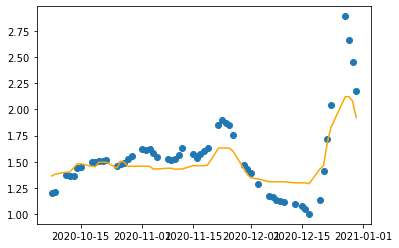

In [331]:
plt.scatter(Australia.index[-58:], y_true)
plt.plot(Australia.index[-58:], y_pred, color='orange')

This model presents overfiting, 

-------------------------------------

Elastic Net Model

In [332]:
model = ElasticNet()
param_search = {'alpha': [0.01, 0.1, 1] , 'l1_ratio':[0.1, 0.2, 0.4, 0.6, 0.8, 0.9]}

tscv = TimeSeriesSplit()
gsearch = GridSearchCV(estimator = model, cv = tscv, param_grid = param_search, scoring = adjr2_score)
gsearch.fit(x_Australia, y_Australia.values.ravel()) 
best_score = gsearch.best_score_ 
best_model = gsearch.best_estimator_
y_true = test_y_Australia.values.ravel()
y_pred = best_model.predict(test_x_Australia)

In [333]:
regression_results(y_true, y_pred)

explained_variance:  -0.3233
r2:  -16.3007
adj r2:  -16.8562
MAE:  1.437
MSE:  2.236
RMSE:  1.4953


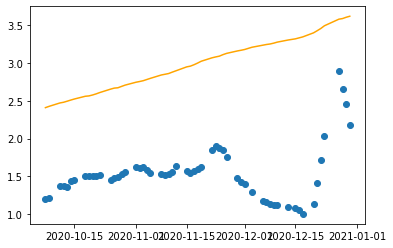

In [334]:
plt.scatter(Australia.index[-58:], y_true)
plt.plot(Australia.index[-58:], y_pred, color='orange')

-------------------------------------

Gradient Boosting Model

In [335]:
model = GradientBoostingRegressor()
param_search = {'n_estimators': [100, 200, 500],
                'n_iter_no_change': [5, 10],
                'validation_fraction': [0.5, 0.2, 0.1]}

tscv = TimeSeriesSplit()
gsearch = GridSearchCV(estimator = model, cv = tscv, param_grid = param_search, scoring = adjr2_score)
gsearch.fit(x_Australia, y_Australia.values.ravel()) 
best_score = gsearch.best_score_ 
best_model = gsearch.best_estimator_
y_true = test_y_Australia.values.ravel()
y_pred = best_model.predict(test_x_Australia)

In [336]:
regression_results(y_true, y_pred)

explained_variance:  0.9959
r2:  0.9958
adj r2:  0.9957
MAE:  0.0173
MSE:  0.0005
RMSE:  0.0233


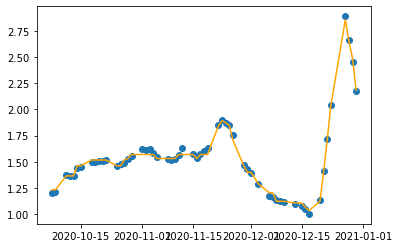

In [337]:
plt.scatter(Australia.index[-58:], y_true)
plt.plot(Australia.index[-58:], y_pred, color='orange')

------------------------

##### 4.2.1.2. Dataset without detrending without 'new_tests_smoothed_per_thousand'

Random Forest Model

In [338]:
x_Australia_drop = x_Australia.drop(columns = ['new_tests_smoothed_per_thousand'])

test_x_Australia_drop = test_x_Australia.drop(columns = ['new_tests_smoothed_per_thousand'])

In [339]:
def adjr2(actual, predict):
    r2 = metrics.r2_score(actual, predict)
    n = Australia.shape[0]
    p = Australia.shape[1] - 1
    adjr = 1-(1 - r2)*(n - 1)/(n - p - 1)
    return adjr

adjr2_score = make_scorer(adjr2, greater_is_better = False)

In [340]:
model = RandomForestRegressor()
param_search = { 
    'n_estimators': [20, 50, 100],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [i for i in range(5,15)]
}
tscv = TimeSeriesSplit()
gsearch = GridSearchCV(estimator = model, cv = tscv, param_grid = param_search, scoring = adjr2_score)
gsearch.fit(x_Australia_drop, y_Australia.values.ravel()) 
best_score = gsearch.best_score_ 
best_model = gsearch.best_estimator_
y_true = test_y_Australia.values.ravel()
y_pred = best_model.predict(test_x_Australia_drop)

In [341]:
regression_results(y_true, y_pred)

explained_variance:  0.0274
r2:  -0.1689
adj r2:  -0.2009
MAE:  0.2728
MSE:  0.1511
RMSE:  0.3887


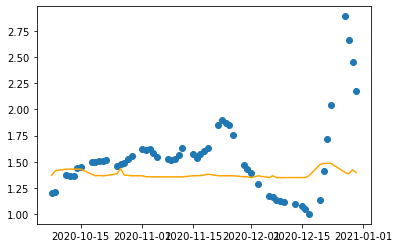

In [342]:
plt.scatter(Australia.index[-58:], y_true)
plt.plot(Australia.index[-58:], y_pred, color='orange')

------------------------

The constructed models present poor prediction results so there most be an error in the chosen approach.

##### 4.2.1.3. Dataset with detrending including 'new_tests_smoothed_per_thousand'

Random Forest Model

In [343]:
y_Australia_diff = tests_Australia_diff.iloc[:int(tests_Australia_diff.shape[0]/4)*3, ]
x_Australia_diff = Australia_diff.iloc[:int(Australia_diff.shape[0]/4)*3, :]

test_y_Australia_diff = tests_Australia_diff.iloc[int(tests_Australia_diff.shape[0]/4)*3:, ]
test_x_Australia_diff = Australia_diff.iloc[int(Australia_diff.shape[0]/4)*3:, :]

In [344]:
def adjr2(actual, predict):
    r2 = metrics.r2_score(actual, predict)
    n = Australia_diff.shape[0]
    p = Australia_diff.shape[1]
    adjr = 1-(1 - r2)*(n - 1)/(n - p - 1)
    return adjr

adjr2_score = make_scorer(adjr2, greater_is_better = False)

In [345]:
model = RandomForestRegressor()
param_search = { 
    'n_estimators': [20, 50, 100],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [i for i in range(5,15)]
}
tscv = TimeSeriesSplit()
gsearch = GridSearchCV(estimator = model, cv = tscv, param_grid = param_search, scoring = adjr2_score)
gsearch.fit(x_Australia_diff, y_Australia_diff.values.ravel()) 
best_score = gsearch.best_score_ 
best_model = gsearch.best_estimator_
y_true = test_y_Australia_diff.values.ravel()
y_pred = best_model.predict(test_x_Australia_diff)

In [346]:
regression_results(y_true, y_pred)

explained_variance:  0.5659
r2:  0.5653
adj r2:  0.545
MAE:  0.0419
MSE:  0.0107
RMSE:  0.1034


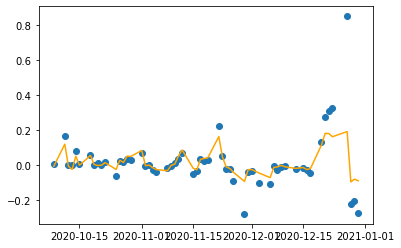

In [347]:
plt.scatter(Australia.index[-57:], y_true)
plt.plot(Australia.index[-57:], y_pred, color='orange')

##### 4.2.1.3. Dataset with detrending without 'new_tests_smoothed_per_thousand'

Random Forest Model

In [348]:
x_Australia_diff_drop = x_Australia_diff.drop(columns = ['new_tests_smoothed_per_thousand'])

test_x_Australia_diff_drop = test_x_Australia_diff.drop(columns = ['new_tests_smoothed_per_thousand'])

In [349]:
def adjr2(actual, predict):
    r2 = metrics.r2_score(actual, predict)
    n = Australia_diff.shape[0]
    p = Australia_diff.shape[1] - 1
    adjr = 1-(1 - r2)*(n - 1)/(n - p - 1)
    return adjr

adjr2_score = make_scorer(adjr2, greater_is_better = False)

In [350]:
model = RandomForestRegressor()
param_search = { 
    'n_estimators': [20, 50, 100],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [i for i in range(5,15)]
}
tscv = TimeSeriesSplit()
gsearch = GridSearchCV(estimator = model, cv = tscv, param_grid = param_search, scoring = adjr2_score)
gsearch.fit(x_Australia_diff_drop, y_Australia_diff.values.ravel()) 
best_score = gsearch.best_score_ 
best_model = gsearch.best_estimator_
y_true = test_y_Australia_diff.values.ravel()
y_pred = best_model.predict(test_x_Australia_diff_drop)

In [351]:
regression_results(y_true, y_pred)

explained_variance:  0.1039
r2:  0.1035
adj r2:  0.066
MAE:  0.0823
MSE:  0.022
RMSE:  0.1485


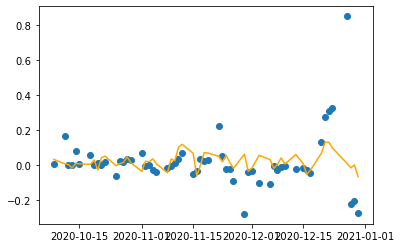

In [352]:
plt.scatter(Australia.index[-57:], y_true)
plt.plot(Australia.index[-57:], y_pred, color='orange')

#### 4.2.2. Luxembourg

##### 4.2.2.1. Dataset without detrending including 'new_tests_smoothed_per_thousand'

In [353]:
y_Luxembourg = tests_Luxembourg.iloc[:int(tests_Luxembourg.shape[0]/4)*3, ]
x_Luxembourg = Luxembourg.iloc[:int(Luxembourg.shape[0]/4)*3, :]

test_y_Luxembourg = tests_Luxembourg.iloc[int(tests_Luxembourg.shape[0]/4)*3:, ]
test_x_Luxembourg = Luxembourg.iloc[int(Luxembourg.shape[0]/4)*3:, :]

In [354]:
def adjr2(actual, predict):
    r2 = metrics.r2_score(actual, predict)
    n = Luxembourg.shape[0]
    p = Luxembourg.shape[1]
    adjr = 1-(1 - r2)*(n - 1)/(n - p - 1)
    return adjr

adjr2_score = make_scorer(adjr2, greater_is_better = False)

Random Forest Model

In [481]:
model = RandomForestRegressor()
param_search = {
    'n_estimators': [20, 50, 100],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [i for i in range(5,15)]
}
tscv = TimeSeriesSplit()
gsearch = GridSearchCV(estimator = model, cv = tscv, param_grid = param_search, scoring = adjr2_score)
gsearch.fit(x_Luxembourg, y_Luxembourg.values.ravel())
best_score = gsearch.best_score_
best_model = gsearch.best_estimator_
y_true = test_y_Luxembourg.values.ravel()
y_pred = best_model.predict(test_x_Luxembourg)

In [482]:
regression_results(y_true, y_pred)

explained_variance:  0.2118
r2:  -7.0349
adj r2:  -7.5533
MAE:  5.335
MSE:  31.5582
RMSE:  5.6177


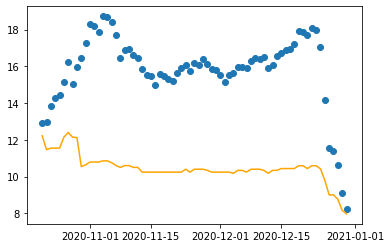

In [483]:
plt.scatter(Luxembourg.index[-71:], y_true)
plt.plot(Luxembourg.index[-71:], y_pred, color='orange')

-------------------------------------

Elastic Net Model

In [358]:
%%capture

model = ElasticNet()
param_search = {'alpha': [0.01, 0.1, 1] , 'l1_ratio':[0.1, 0.2, 0.4, 0.6, 0.8, 0.9]}
tscv = TimeSeriesSplit()
gsearch = GridSearchCV(estimator = model, cv = tscv, param_grid = param_search, scoring = 'r2')
gsearch.fit(x_Luxembourg, y_Luxembourg.values.ravel())
best_score = gsearch.best_score_
best_model = gsearch.best_estimator_
y_true = test_y_Luxembourg.values.ravel()
y_pred = best_model.predict(test_x_Luxembourg)

In [359]:
regression_results(y_true, y_pred)

explained_variance:  -7.2133
r2:  -31.8049
adj r2:  -33.2738
MAE:  9.8278
MSE:  128.8456
RMSE:  11.351


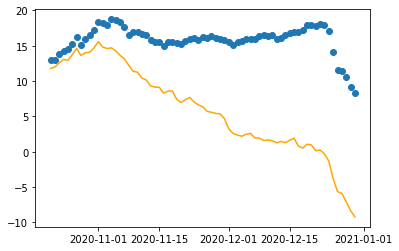

In [360]:
plt.scatter(Luxembourg.index[-71:], y_true)
plt.plot(Luxembourg.index[-71:], y_pred, color='orange')

-------------------------------------

Gradient Boosting Model

In [361]:
model = GradientBoostingRegressor()
param_search = {'n_estimators': [100, 200, 500],
                'n_iter_no_change': [5, 10],
                'validation_fraction': [0.5, 0.2, 0.1]}
tscv = TimeSeriesSplit()
gsearch = GridSearchCV(estimator = model, cv = tscv, param_grid = param_search, scoring = adjr2_score)
gsearch.fit(x_Luxembourg, y_Luxembourg.values.ravel())
best_score = gsearch.best_score_
best_model = gsearch.best_estimator_
y_true = test_y_Luxembourg.values.ravel()
y_pred = best_model.predict(test_x_Luxembourg)

In [362]:
regression_results(y_true, y_pred)

explained_variance:  0.9392
r2:  0.8578
adj r2:  0.8514
MAE:  0.6013
MSE:  0.5587
RMSE:  0.7475


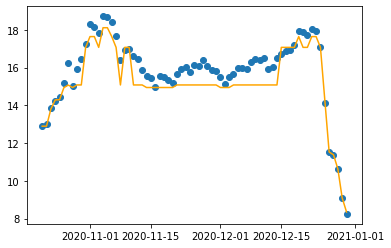

In [363]:
plt.scatter(Luxembourg.index[-71:], y_true)
plt.plot(Luxembourg.index[-71:], y_pred, color='orange')

-----------------------

#### 4.2.3. Ukraine

In [364]:
y_Ukraine = tests_Ukraine.iloc[:int(tests_Ukraine.shape[0]/4)*3, ]
x_Ukraine = Ukraine.iloc[:int(Ukraine.shape[0]/4)*3, :]

test_y_Ukraine = tests_Ukraine.iloc[int(tests_Ukraine.shape[0]/4)*3:, ]
test_x_Ukraine = Ukraine.iloc[int(Ukraine.shape[0]/4)*3:, :]

In [365]:
def adjr2(actual, predict):
    r2 = metrics.r2_score(actual, predict)
    n = Ukraine.shape[0]
    p = Ukraine.shape[1]
    adjr = 1-(1 - r2)*(n - 1)/(n - p - 1)
    return adjr

adjr2_score = make_scorer(adjr2, greater_is_better = False)

Random Forest Model

In [366]:
model = RandomForestRegressor()
param_search = { 
    'n_estimators': [20, 50, 100],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [i for i in range(5,15)]
}
tscv = TimeSeriesSplit()
gsearch = GridSearchCV(estimator = model, cv = tscv, param_grid = param_search, scoring = 'r2')
gsearch.fit(x_Ukraine, y_Ukraine.values.ravel()) 
best_score = gsearch.best_score_ 
best_model = gsearch.best_estimator_
y_true = test_y_Ukraine.values.ravel()
y_pred = best_model.predict(test_x_Ukraine)

In [367]:
regression_results(y_true, y_pred)

explained_variance:  0.1478
r2:  -1.0818
adj r2:  -1.1786
MAE:  0.1521
MSE:  0.0338
RMSE:  0.1839


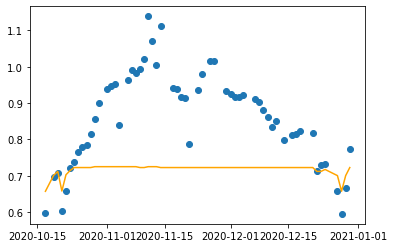

In [368]:
plt.scatter(Ukraine.index[-y_true.size:], y_true)
plt.plot(Ukraine.index[-y_true.size:], y_pred, color='orange')

-------------------------------------

Elastic Net Model

In [484]:
%%capture

model = ElasticNet()
param_search = {'alpha': [0.01, 0.1, 1] , 'l1_ratio':[0.1, 0.2, 0.4, 0.6, 0.8, 0.9]}
tscv = TimeSeriesSplit()
gsearch = GridSearchCV(estimator = model, cv = tscv, param_grid = param_search, scoring = 'r2')
gsearch.fit(x_Ukraine, y_Ukraine.values.ravel())
best_score = gsearch.best_score_
best_model = gsearch.best_estimator_
y_true = test_y_Ukraine.values.ravel()
y_pred = best_model.predict(test_x_Ukraine)

In [485]:
regression_results(y_true, y_pred)

explained_variance:  -9.115
r2:  -15.0967
adj r2:  -16.1352
MAE:  0.3274
MSE:  0.2616
RMSE:  0.5114


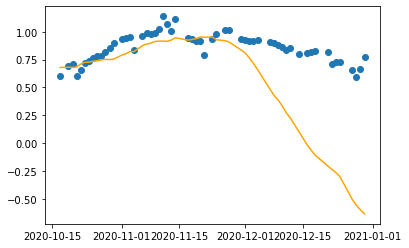

In [486]:
plt.scatter(Ukraine.index[-y_true.size:], y_true)
plt.plot(Ukraine.index[-y_true.size:], y_pred, color='orange')

-------------------------------------

Gradient Boosting Model

In [372]:
model = GradientBoostingRegressor()
param_search = {'n_estimators': [100, 200, 500],
                'n_iter_no_change': [5, 10],
                'validation_fraction': [0.5, 0.2, 0.1]}
tscv = TimeSeriesSplit()
gsearch = GridSearchCV(estimator = model, cv = tscv, param_grid = param_search, scoring = 'r2')
gsearch.fit(x_Ukraine, y_Ukraine.values.ravel())
best_score = gsearch.best_score_
best_model = gsearch.best_estimator_
y_true = test_y_Ukraine.values.ravel()
y_pred = best_model.predict(test_x_Ukraine)

In [373]:
regression_results(y_true, y_pred)

explained_variance:  0.2136
r2:  -0.2941
adj r2:  -0.3542
MAE:  0.1175
MSE:  0.021
RMSE:  0.145


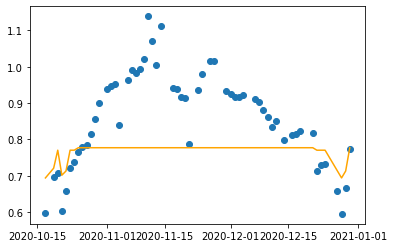

In [374]:
plt.scatter(Ukraine.index[-y_true.size:], y_true)
plt.plot(Ukraine.index[-y_true.size:], y_pred, color='orange')

#### 4.2.4. Israel

In [375]:
y_Israel = tests_Israel.iloc[:int(tests_Israel.shape[0]/4)*3, ]
x_Israel = Israel.iloc[:int(Israel.shape[0]/4)*3, :]

test_y_Israel = tests_Israel.iloc[int(tests_Israel.shape[0]/4)*3:, ]
test_x_Israel = Israel.iloc[int(Israel.shape[0]/4)*3:, :]

In [376]:
def adjr2(actual, predict):
    r2 = metrics.r2_score(actual, predict)
    n = Israel.shape[0]
    p = Israel.shape[1]
    adjr = 1-(1 - r2)*(n - 1)/(n - p - 1)
    return adjr

adjr2_score = make_scorer(adjr2, greater_is_better = False)

Random Forest Model

In [377]:
model = RandomForestRegressor()
param_search = { 
    'n_estimators': [20, 50, 100],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [i for i in range(5,15)]
}
tscv = TimeSeriesSplit()
gsearch = GridSearchCV(estimator = model, cv = tscv, param_grid = param_search, scoring = 'r2')
gsearch.fit(x_Israel, y_Israel.values.ravel()) 
best_score = gsearch.best_score_ 
best_model = gsearch.best_estimator_
y_true = test_y_Israel.values.ravel()
y_pred = best_model.predict(test_x_Israel)

In [378]:
regression_results(y_true, y_pred)

explained_variance:  0.4858
r2:  0.2464
adj r2:  0.2162
MAE:  1.3014
MSE:  4.4617
RMSE:  2.1123


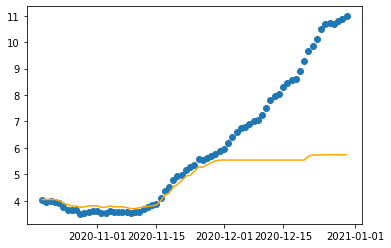

In [379]:
plt.scatter(Israel.index[-y_true.size:], y_true)
plt.plot(Israel.index[-y_true.size:], y_pred, color='orange')

-------------------------------------

Elastic Net Model

In [380]:
%%capture

model = ElasticNet()
param_search = {'alpha': [0.01, 0.1, 1] , 'l1_ratio':[0.1, 0.2, 0.4, 0.6, 0.8, 0.9]}
tscv = TimeSeriesSplit()
gsearch = GridSearchCV(estimator = model, cv = tscv, param_grid = param_search, scoring = 'r2')
gsearch.fit(x_Israel, y_Israel.values.ravel())
best_score = gsearch.best_score_
best_model = gsearch.best_estimator_
y_true = test_y_Israel.values.ravel()
y_pred = best_model.predict(test_x_Israel)

In [381]:
regression_results(y_true, y_pred)

explained_variance:  0.8539
r2:  0.6551
adj r2:  0.6412
MAE:  1.0986
MSE:  2.0423
RMSE:  1.4291


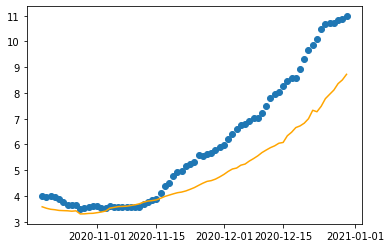

In [382]:
plt.scatter(Israel.index[-y_true.size:], y_true)
plt.plot(Israel.index[-y_true.size:], y_pred, color='orange')

-------------------------------------

Gradient Boosting Model

In [383]:
model = GradientBoostingRegressor()
param_search = {'n_estimators': [100, 200, 500],
                'n_iter_no_change': [5, 10],
                'validation_fraction': [0.5, 0.2, 0.1]}
tscv = TimeSeriesSplit()
gsearch = GridSearchCV(estimator = model, cv = tscv, param_grid = param_search, scoring = 'r2')
gsearch.fit(x_Israel, y_Israel.values.ravel())
best_score = gsearch.best_score_
best_model = gsearch.best_estimator_
y_true = test_y_Israel.values.ravel()
y_pred = best_model.predict(test_x_Israel)

In [384]:
regression_results(y_true, y_pred)

explained_variance:  0.5162
r2:  0.2985
adj r2:  0.2703
MAE:  1.1886
MSE:  4.1535
RMSE:  2.038


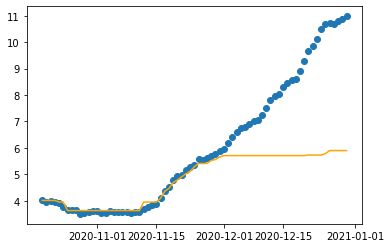

In [385]:
plt.scatter(Israel.index[-y_true.size:], y_true)
plt.plot(Israel.index[-y_true.size:], y_pred, color='orange')

#### 4.2.5. Nepal

In [386]:
y_Nepal = tests_Nepal.iloc[:int(tests_Nepal.shape[0]/4)*3, ]
x_Nepal = Nepal.iloc[:int(Nepal.shape[0]/4)*3, :]

test_y_Nepal = tests_Nepal.iloc[int(tests_Nepal.shape[0]/4)*3:, ]
test_x_Nepal = Nepal.iloc[int(Nepal.shape[0]/4)*3:, :]

In [387]:
def adjr2(actual, predict):
    r2 = metrics.r2_score(actual, predict)
    n = Nepal.shape[0]
    p = Nepal.shape[1]
    adjr = 1-(1 - r2)*(n - 1)/(n - p - 1)
    return adjr

adjr2_score = make_scorer(adjr2, greater_is_better = False)

In [487]:
model = RandomForestRegressor()
param_search = { 
    'n_estimators': [20, 50, 100],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [i for i in range(5,15)]
}
tscv = TimeSeriesSplit()
gsearch = GridSearchCV(estimator = model, cv = tscv, param_grid = param_search, scoring = adjr2_score)
gsearch.fit(x_Nepal, y_Nepal.values.ravel()) 
best_score = gsearch.best_score_ 
best_model = gsearch.best_estimator_
y_true = test_y_Nepal.values.ravel()
y_pred = best_model.predict(test_x_Nepal)

In [488]:
regression_results(y_true, y_pred)

explained_variance:  0.6641
r2:  -0.6295
adj r2:  -0.7346
MAE:  0.0834
MSE:  0.0088
RMSE:  0.0936


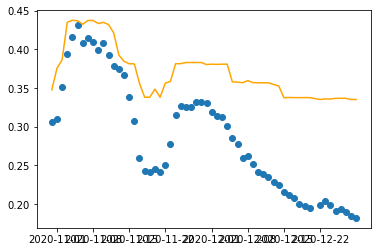

In [489]:
plt.scatter(Nepal.index[-y_true.size:], y_true)
plt.plot(Nepal.index[-y_true.size:], y_pred, color='orange')

-------------------------------------

Elastic Net Model

In [391]:
%%capture

model = ElasticNet()
param_search = {'alpha': [0.01, 0.1, 1] , 'l1_ratio':[0.1, 0.2, 0.4, 0.6, 0.8, 0.9]}
tscv = TimeSeriesSplit()
gsearch = GridSearchCV(estimator = model, cv = tscv, param_grid = param_search, scoring = adjr2_score)
gsearch.fit(x_Nepal, y_Nepal.values.ravel())
best_score = gsearch.best_score_
best_model = gsearch.best_estimator_
y_true = test_y_Nepal.values.ravel()
y_pred = best_model.predict(test_x_Nepal)

In [392]:
regression_results(y_true, y_pred)

explained_variance:  0.4084
r2:  -3.3599
adj r2:  -3.5618
MAE:  0.1425
MSE:  0.0234
RMSE:  0.1531


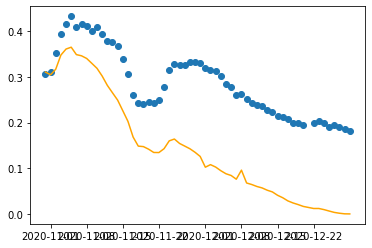

In [393]:
plt.scatter(Nepal.index[-y_true.size:], y_true)
plt.plot(Nepal.index[-y_true.size:], y_pred, color='orange')

-------------------------------------

Gradient Boosting Model

In [394]:
model = GradientBoostingRegressor()
param_search = {'n_estimators': [100, 200, 500],
                'n_iter_no_change': [5, 10],
                'validation_fraction': [0.5, 0.2, 0.1]}
tscv = TimeSeriesSplit()
gsearch = GridSearchCV(estimator = model, cv = tscv, param_grid = param_search, scoring = 'r2')
gsearch.fit(x_Nepal, y_Nepal.values.ravel())
best_score = gsearch.best_score_
best_model = gsearch.best_estimator_
y_true = test_y_Nepal.values.ravel()
y_pred = best_model.predict(test_x_Nepal)

In [395]:
regression_results(y_true, y_pred)

explained_variance:  0.8173
r2:  0.6166
adj r2:  0.5988
MAE:  0.0341
MSE:  0.0021
RMSE:  0.0454


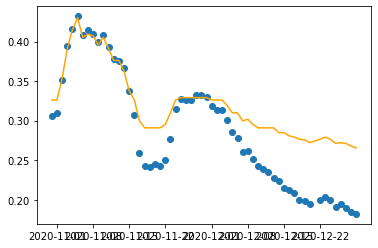

In [396]:
plt.scatter(Nepal.index[-y_true.size:], y_true)
plt.plot(Nepal.index[-y_true.size:], y_pred, color='orange')

#### 4.2.6. Chile

In [397]:
y_Chile = tests_Chile.iloc[:int(tests_Chile.shape[0]/4)*3, ]
x_Chile = Chile.iloc[:int(Chile.shape[0]/4)*3, :]

test_y_Chile = tests_Chile.iloc[int(tests_Chile.shape[0]/4)*3:, ]
test_x_Chile = Chile.iloc[int(Chile.shape[0]/4)*3:, :]

In [398]:
def adjr2(actual, predict):
    r2 = metrics.r2_score(actual, predict)
    n = Chile.shape[0]
    p = Chile.shape[1]
    adjr = 1-(1 - r2)*(n - 1)/(n - p - 1)
    return adjr

adjr2_score = make_scorer(adjr2, greater_is_better = False)

In [399]:
model = RandomForestRegressor()
param_search = { 
    'n_estimators': [20, 50, 100],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [i for i in range(5,15)]
}
tscv = TimeSeriesSplit()
gsearch = GridSearchCV(estimator = model, cv = tscv, param_grid = param_search, scoring = 'r2')
gsearch.fit(x_Chile, y_Chile.values.ravel()) 
best_score = gsearch.best_score_ 
best_model = gsearch.best_estimator_
y_true = test_y_Chile.values.ravel()
y_pred = best_model.predict(test_x_Chile)

In [400]:
regression_results(y_true, y_pred)

explained_variance:  0.2671
r2:  0.0495
adj r2:  0.0123
MAE:  0.0708
MSE:  0.0201
RMSE:  0.1417


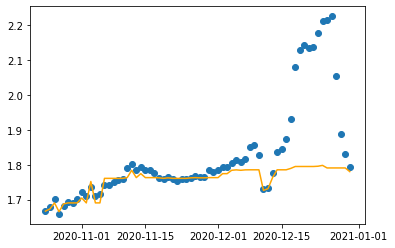

In [401]:
plt.scatter(Chile.index[-y_true.size:], y_true)
plt.plot(Chile.index[-y_true.size:], y_pred, color='orange')

-------------------------------------

Elastic Net Model

In [402]:
%%capture

model = ElasticNet()
param_search = {'alpha': [0.01, 0.1, 1] , 'l1_ratio':[0.1, 0.2, 0.4, 0.6, 0.8, 0.9]}
tscv = TimeSeriesSplit()
gsearch = GridSearchCV(estimator = model, cv = tscv, param_grid = param_search, scoring = 'r2')
gsearch.fit(x_Chile, y_Chile.values.ravel())
best_score = gsearch.best_score_
best_model = gsearch.best_estimator_
y_true = test_y_Chile.values.ravel()
y_pred = best_model.predict(test_x_Chile)

In [403]:
regression_results(y_true, y_pred)

explained_variance:  0.3858
r2:  -2.0247
adj r2:  -2.1433
MAE:  0.2256
MSE:  0.0639
RMSE:  0.2528


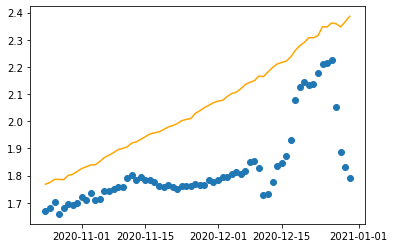

In [404]:
plt.scatter(Chile.index[-y_true.size:], y_true)
plt.plot(Chile.index[-y_true.size:], y_pred, color='orange')

-------------------------------------

Gradient Boosting Model

In [405]:
model = GradientBoostingRegressor()
param_search = {'n_estimators': [100, 200, 500],
                'n_iter_no_change': [5, 10],
                'validation_fraction': [0.5, 0.2, 0.1]}
tscv = TimeSeriesSplit()
gsearch = GridSearchCV(estimator = model, cv = tscv, param_grid = param_search, scoring = adjr2_score)
gsearch.fit(x_Chile, y_Chile.values.ravel())
best_score = gsearch.best_score_
best_model = gsearch.best_estimator_
y_true = test_y_Chile.values.ravel()
y_pred = best_model.predict(test_x_Chile)

In [406]:
regression_results(y_true, y_pred)

explained_variance:  0.2983
r2:  0.0615
adj r2:  0.0247
MAE:  0.0722
MSE:  0.0198
RMSE:  0.1408


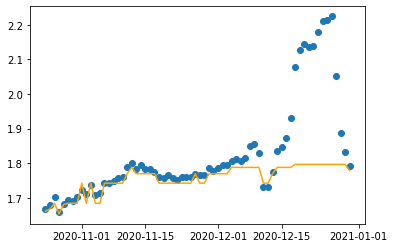

In [407]:
plt.scatter(Chile.index[-y_true.size:], y_true)
plt.plot(Chile.index[-y_true.size:], y_pred, color='orange')

#### 4.2.7. Bolivia

In [408]:
y_Bolivia = tests_Bolivia.iloc[:int(tests_Bolivia.shape[0]/4)*3, ]
x_Bolivia = Bolivia.iloc[:int(Bolivia.shape[0]/4)*3, :]

test_y_Bolivia = tests_Bolivia.iloc[int(tests_Bolivia.shape[0]/4)*3:, ]
test_x_Bolivia = Bolivia.iloc[int(Bolivia.shape[0]/4)*3:, :]

In [409]:
def adjr2(actual, predict):
    r2 = metrics.r2_score(actual, predict)
    n = Bolivia.shape[0]
    p = Bolivia.shape[1]
    adjr = 1-(1 - r2)*(n - 1)/(n - p - 1)
    return adjr

adjr2_score = make_scorer(adjr2, greater_is_better = False)

In [410]:
model = RandomForestRegressor()
param_search = { 
    'n_estimators': [20, 50, 100],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [i for i in range(5,15)]
}
tscv = TimeSeriesSplit()
gsearch = GridSearchCV(estimator = model, cv = tscv, param_grid = param_search, scoring = adjr2_score)
gsearch.fit(x_Bolivia, y_Bolivia.values.ravel()) 
best_score = gsearch.best_score_ 
best_model = gsearch.best_estimator_
y_true = test_y_Bolivia.values.ravel()
y_pred = best_model.predict(test_x_Bolivia)

In [411]:
regression_results(y_true, y_pred)

explained_variance:  0.8424
r2:  0.6645
adj r2:  0.6512
MAE:  0.0143
MSE:  0.0003
RMSE:  0.0181


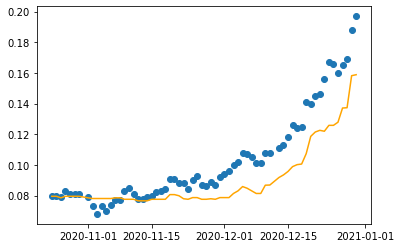

In [412]:
plt.scatter(Bolivia.index[-y_true.size:], y_true)
plt.plot(Bolivia.index[-y_true.size:], y_pred, color='orange')

-------------------------------------

Elastic Net Model

In [413]:
%%capture

model = ElasticNet()
param_search = {'alpha': [0.01, 0.1, 1] , 'l1_ratio':[0.1, 0.2, 0.4, 0.6, 0.8, 0.9]}
tscv = TimeSeriesSplit()
gsearch = GridSearchCV(estimator = model, cv = tscv, param_grid = param_search, scoring = 'r2')
gsearch.fit(x_Bolivia, y_Bolivia.values.ravel())
best_score = gsearch.best_score_
best_model = gsearch.best_estimator_
y_true = test_y_Bolivia.values.ravel()
y_pred = best_model.predict(test_x_Bolivia)

In [414]:
regression_results(y_true, y_pred)

explained_variance:  0.8755
r2:  0.8751
adj r2:  0.8702
MAE:  0.0096
MSE:  0.0001
RMSE:  0.011


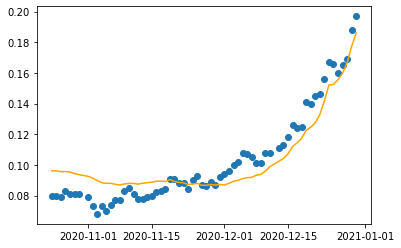

In [415]:
plt.scatter(Bolivia.index[-y_true.size:], y_true)
plt.plot(Bolivia.index[-y_true.size:], y_pred, color='orange')

-------------------------------------

Gradient Boosting Model

In [416]:
model = GradientBoostingRegressor()
param_search = {'n_estimators': [100, 200, 500],
                'n_iter_no_change': [5, 10],
                'validation_fraction': [0.5, 0.2, 0.1]}
tscv = TimeSeriesSplit()
gsearch = GridSearchCV(estimator = model, cv = tscv, param_grid = param_search, scoring = adjr2_score)
gsearch.fit(x_Bolivia, y_Bolivia.values.ravel())
best_score = gsearch.best_score_
best_model = gsearch.best_estimator_
y_true = test_y_Bolivia.values.ravel()
y_pred = best_model.predict(test_x_Bolivia)

In [417]:
regression_results(y_true, y_pred)

explained_variance:  0.9824
r2:  0.9732
adj r2:  0.9721
MAE:  0.0044
MSE:  0.0
RMSE:  0.0051


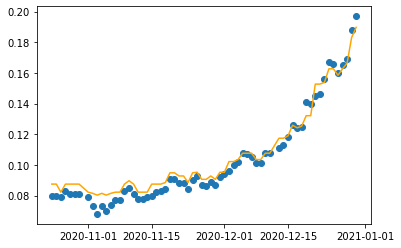

In [418]:
plt.scatter(Bolivia.index[-y_true.size:], y_true)
plt.plot(Bolivia.index[-y_true.size:], y_pred, color='orange')

#### 4.2.8. United States 

In [419]:
y_USA = tests_USA.iloc[:int(tests_USA.shape[0]/4)*3, ]
x_USA = USA.iloc[:int(USA.shape[0]/4)*3, :]

test_y_USA = tests_USA.iloc[int(tests_USA.shape[0]/4)*3:, ]
test_x_USA = USA.iloc[int(USA.shape[0]/4)*3:, :]

In [420]:
def adjr2(actual, predict):
    r2 = metrics.r2_score(actual, predict)
    n = USA.shape[0]
    p = USA.shape[1]
    adjr = 1-(1 - r2)*(n - 1)/(n - p - 1)
    return adjr

adjr2_score = make_scorer(adjr2, greater_is_better = False)

In [421]:
model = RandomForestRegressor()
param_search = { 
    'n_estimators': [20, 50, 100],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [i for i in range(5,15)]
}
tscv = TimeSeriesSplit()
gsearch = GridSearchCV(estimator = model, cv = tscv, param_grid = param_search, scoring = 'r2')
gsearch.fit(x_USA, y_USA.values.ravel()) 
best_score = gsearch.best_score_ 
best_model = gsearch.best_estimator_
y_true = test_y_USA.values.ravel()
y_pred = best_model.predict(test_x_USA)

In [422]:
regression_results(y_true, y_pred)

explained_variance:  -0.5082
r2:  -4.7985
adj r2:  -7.1179
MAE:  1.7623
MSE:  4.1976
RMSE:  2.0488


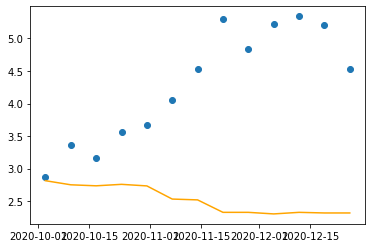

In [423]:
plt.scatter(USA.index[-y_true.size:], y_true)
plt.plot(USA.index[-y_true.size:], y_pred, color='orange')

-------------------------------------

Elastic Net Model

In [424]:
%%capture

model = ElasticNet()
param_search = {'alpha': [0.01, 0.1, 1] , 'l1_ratio':[0.1, 0.2, 0.4, 0.6, 0.8, 0.9]}
tscv = TimeSeriesSplit()
gsearch = GridSearchCV(estimator = model, cv = tscv, param_grid = param_search, scoring = 'r2')
gsearch.fit(x_USA, y_USA.values.ravel())
best_score = gsearch.best_score_
best_model = gsearch.best_estimator_
y_true = test_y_USA.values.ravel()
y_pred = best_model.predict(test_x_USA)

In [425]:
regression_results(y_true, y_pred)

explained_variance:  0.2306
r2:  -0.6536
adj r2:  -1.3151
MAE:  0.8564
MSE:  1.1971
RMSE:  1.0941


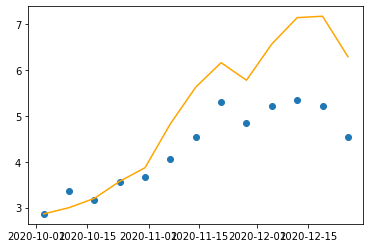

In [426]:
plt.scatter(USA.index[-y_true.size:], y_true)
plt.plot(USA.index[-y_true.size:], y_pred, color='orange')

-------------------------------------

Gradient Boosting Model

In [427]:
model = GradientBoostingRegressor()
param_search = {'n_estimators': [100, 200, 500],
                'n_iter_no_change': [5, 10],
                'validation_fraction': [0.5, 0.2, 0.1]}
tscv = TimeSeriesSplit()
gsearch = GridSearchCV(estimator = model, cv = tscv, param_grid = param_search, scoring = 'r2')
gsearch.fit(x_USA, y_USA.values.ravel())
best_score = gsearch.best_score_
best_model = gsearch.best_estimator_
y_true = test_y_USA.values.ravel()
y_pred = best_model.predict(test_x_USA)

In [428]:
regression_results(y_true, y_pred)

explained_variance:  0.0376
r2:  -2.7591
adj r2:  -4.2628
MAE:  1.4229
MSE:  2.7213
RMSE:  1.6496


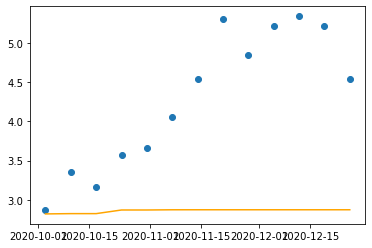

In [429]:
plt.scatter(USA.index[-y_true.size:], y_true)
plt.plot(USA.index[-y_true.size:], y_pred, color='orange')

#### 4.2.9. El Salvador

In [430]:
y_Salvador = tests_Salvador.iloc[:int(tests_Salvador.shape[0]/4)*3, ]
x_Salvador = Salvador.iloc[:int(Salvador.shape[0]/4)*3, :]

test_y_Salvador = tests_Salvador.iloc[int(tests_Salvador.shape[0]/4)*3:, ]
test_x_Salvador = Salvador.iloc[int(Salvador.shape[0]/4)*3:, :]

In [431]:
def adjr2(actual, predict):
    r2 = metrics.r2_score(actual, predict)
    n = Salvador.shape[0]
    p = Salvador.shape[1]
    adjr = 1-(1 - r2)*(n - 1)/(n - p - 1)
    return adjr

adjr2_score = make_scorer(adjr2, greater_is_better = False)

Random Forest Model

In [432]:
model = RandomForestRegressor()
param_search = { 
    'n_estimators': [20, 50, 100],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [i for i in range(5,15)]
}
tscv = TimeSeriesSplit()
gsearch = GridSearchCV(estimator = model, cv = tscv, param_grid = param_search, scoring = 'r2')
gsearch.fit(x_Salvador, y_Salvador.values.ravel()) 
best_score = gsearch.best_score_ 
best_model = gsearch.best_estimator_
y_true = test_y_Salvador.values.ravel()
y_pred = best_model.predict(test_x_Salvador)

In [433]:
regression_results(y_true, y_pred)

explained_variance:  0.2735
r2:  -8.8889
adj r2:  -9.3621
MAE:  0.0926
MSE:  0.0092
RMSE:  0.0962


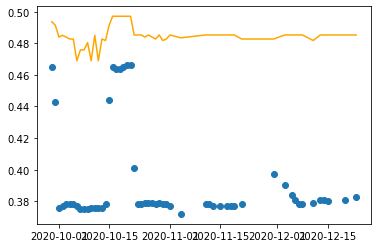

In [434]:
plt.scatter(Salvador.index[-y_true.size:], y_true)
plt.plot(Salvador.index[-y_true.size:], y_pred, color='orange')

-------------------------------------

Elastic Net Model

In [435]:
%%capture

model = ElasticNet()
param_search = {'alpha': [0.01, 0.1, 1] , 'l1_ratio':[0.1, 0.2, 0.4, 0.6, 0.8, 0.9]}
tscv = TimeSeriesSplit()
gsearch = GridSearchCV(estimator = model, cv = tscv, param_grid = param_search, scoring = 'r2')
gsearch.fit(x_Salvador, y_Salvador.values.ravel())
best_score = gsearch.best_score_
best_model = gsearch.best_estimator_
y_true = test_y_Salvador.values.ravel()
y_pred = best_model.predict(test_x_Salvador)

In [436]:
regression_results(y_true, y_pred)

explained_variance:  -2.039
r2:  -17.1641
adj r2:  -18.0332
MAE:  0.1192
MSE:  0.017
RMSE:  0.1303


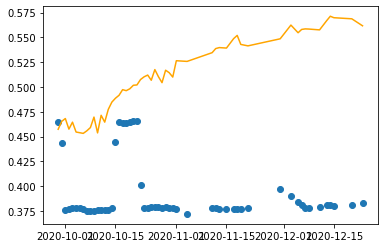

In [437]:
plt.scatter(Salvador.index[-y_true.size:], y_true)
plt.plot(Salvador.index[-y_true.size:], y_pred, color='orange')

-------------------------------------

Gradient Boosting Model

In [438]:
model = GradientBoostingRegressor()
param_search = {'n_estimators': [100, 200, 500],
                'n_iter_no_change': [5, 10],
                'validation_fraction': [0.5, 0.2, 0.1]}
tscv = TimeSeriesSplit()
gsearch = GridSearchCV(estimator = model, cv = tscv, param_grid = param_search, scoring = 'r2')
gsearch.fit(x_Salvador, y_Salvador.values.ravel())
best_score = gsearch.best_score_
best_model = gsearch.best_estimator_
y_true = test_y_Salvador.values.ravel()
y_pred = best_model.predict(test_x_Salvador)

In [439]:
regression_results(y_true, y_pred)

explained_variance:  0.6003
r2:  -2.4105
adj r2:  -2.5736
MAE:  0.0531
MSE:  0.0032
RMSE:  0.0565


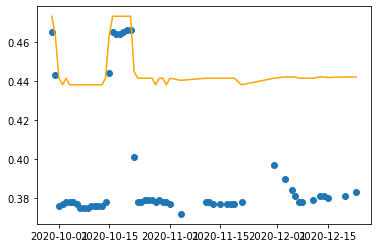

In [440]:
plt.scatter(Salvador.index[-y_true.size:], y_true)
plt.plot(Salvador.index[-y_true.size:], y_pred, color='orange')

## confirmar dados el salvador se não substituidos por 0 devido na

#### 4.2.10. Tunisia

In [441]:
y_Tunisia = tests_Tunisia.iloc[:int(tests_Tunisia.shape[0]/4)*3, ]
x_Tunisia = Tunisia.iloc[:int(Tunisia.shape[0]/4)*3, :]

test_y_Tunisia = tests_Tunisia.iloc[int(tests_Tunisia.shape[0]/4)*3:, ]
test_x_Tunisia = Tunisia.iloc[int(Tunisia.shape[0]/4)*3:, :]

In [442]:
def adjr2(actual, predict):
    r2 = metrics.r2_score(actual, predict)
    n = Tunisia.shape[0]
    p = Tunisia.shape[1]
    adjr = 1-(1 - r2)*(n - 1)/(n - p - 1)
    return adjr

adjr2_score = make_scorer(adjr2, greater_is_better = False)

In [443]:
model = RandomForestRegressor()
param_search = { 
    'n_estimators': [20, 50, 100],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [i for i in range(5,15)]
}
tscv = TimeSeriesSplit()
gsearch = GridSearchCV(estimator = model, cv = tscv, param_grid = param_search, scoring = 'r2')
gsearch.fit(x_Tunisia, y_Tunisia.values.ravel()) 
best_score = gsearch.best_score_ 
best_model = gsearch.best_estimator_
y_true = test_y_Tunisia.values.ravel()
y_pred = best_model.predict(test_x_Tunisia)

In [444]:
regression_results(y_true, y_pred)

explained_variance:  0.231
r2:  -0.624
adj r2:  -0.7242
MAE:  0.062
MSE:  0.0073
RMSE:  0.0854


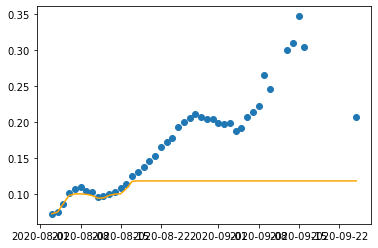

In [445]:
plt.scatter(Tunisia.index[-y_true.size:], y_true)
plt.plot(Tunisia.index[-y_true.size:], y_pred, color='orange')

-------------------------------------

Elastic Net Model

In [446]:
model = ElasticNet()
param_search = {'alpha': [0.01, 0.1, 1] , 'l1_ratio':[0.1, 0.2, 0.4, 0.6, 0.8, 0.9]}
tscv = TimeSeriesSplit()
gsearch = GridSearchCV(estimator = model, cv = tscv, param_grid = param_search, scoring = 'r2')
gsearch.fit(x_Tunisia, y_Tunisia.values.ravel())
best_score = gsearch.best_score_
best_model = gsearch.best_estimator_
y_true = test_y_Tunisia.values.ravel()
y_pred = best_model.predict(test_x_Tunisia)

In [447]:
regression_results(y_true, y_pred)

explained_variance:  -0.0089
r2:  -3.0271
adj r2:  -3.2757
MAE:  0.1164
MSE:  0.0181
RMSE:  0.1345


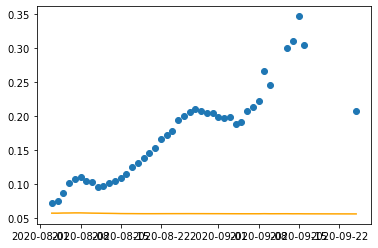

In [448]:
plt.scatter(Tunisia.index[-y_true.size:], y_true)
plt.plot(Tunisia.index[-y_true.size:], y_pred, color='orange')

-------------------------------------

Gradient Boosting Model

In [449]:
model = GradientBoostingRegressor()
param_search = {'n_estimators': [100, 200, 500],
                'n_iter_no_change': [5, 10],
                'validation_fraction': [0.5, 0.2, 0.1]}
tscv = TimeSeriesSplit()
gsearch = GridSearchCV(estimator = model, cv = tscv, param_grid = param_search, scoring = 'r2')
gsearch.fit(x_Tunisia, y_Tunisia.values.ravel())
best_score = gsearch.best_score_
best_model = gsearch.best_estimator_
y_true = test_y_Tunisia.values.ravel()
y_pred = best_model.predict(test_x_Tunisia)

In [450]:
regression_results(y_true, y_pred)

explained_variance:  0.2184
r2:  -0.7821
adj r2:  -0.8921
MAE:  0.067
MSE:  0.008
RMSE:  0.0894


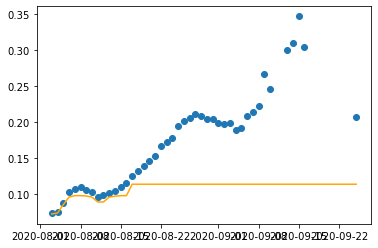

In [451]:
plt.scatter(Tunisia.index[-y_true.size:], y_true)
plt.plot(Tunisia.index[-y_true.size:], y_pred, color='orange')

#### 4.2.11. Malawi

In [452]:
y_Malawi = tests_Malawi.iloc[:int(tests_Malawi.shape[0]/4)*3, ]
x_Malawi = Malawi.iloc[:int(Malawi.shape[0]/4)*3, :]

test_y_Malawi = tests_Malawi.iloc[int(tests_Malawi.shape[0]/4)*3:, ]
test_x_Malawi = Malawi.iloc[int(Malawi.shape[0]/4)*3:, :]

In [453]:
def adjr2(actual, predict):
    r2 = metrics.r2_score(actual, predict)
    n = Malawi.shape[0]
    p = Malawi.shape[1]
    adjr = 1-(1 - r2)*(n - 1)/(n - p - 1)
    return adjr

adjr2_score = make_scorer(adjr2, greater_is_better = False)

In [454]:
model = RandomForestRegressor()
param_search = { 
    'n_estimators': [20, 50, 100],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [i for i in range(5,15)]
}
tscv = TimeSeriesSplit()
gsearch = GridSearchCV(estimator = model, cv = tscv, param_grid = param_search, scoring = adjr2_score)
gsearch.fit(x_Malawi, y_Malawi.values.ravel()) 
best_score = gsearch.best_score_ 
best_model = gsearch.best_estimator_
y_true = test_y_Malawi.values.ravel()
y_pred = best_model.predict(test_x_Malawi)

In [455]:
regression_results(y_true, y_pred)

explained_variance:  0.5041
r2:  -0.0526
adj r2:  -0.1205
MAE:  0.0035
MSE:  0.0
RMSE:  0.0043


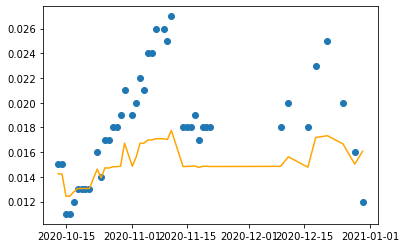

In [456]:
plt.scatter(Malawi.index[-y_true.size:], y_true)
plt.plot(Malawi.index[-y_true.size:], y_pred, color='orange')

-------------------------------------

Elastic Net Model

In [457]:
model = ElasticNet()
param_search = {'alpha': [0.01, 0.1, 1] , 'l1_ratio':[0.1, 0.2, 0.4, 0.6, 0.8, 0.9]}
tscv = TimeSeriesSplit()
gsearch = GridSearchCV(estimator = model, cv = tscv, param_grid = param_search, scoring = 'r2')
gsearch.fit(x_Malawi, y_Malawi.values.ravel())
best_score = gsearch.best_score_
best_model = gsearch.best_estimator_
y_true = test_y_Malawi.values.ravel()
y_pred = best_model.predict(test_x_Malawi)

In [458]:
regression_results(y_true, y_pred)

explained_variance:  0.1478
r2:  -2.3353
adj r2:  -2.5504
MAE:  0.0067
MSE:  0.0001
RMSE:  0.0077


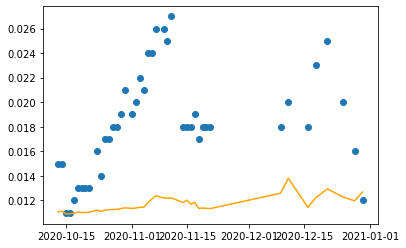

In [459]:
plt.scatter(Malawi.index[-y_true.size:], y_true)
plt.plot(Malawi.index[-y_true.size:], y_pred, color='orange')

-------------------------------------

Gradient Boosting Model

In [460]:
model = GradientBoostingRegressor()
param_search = {'n_estimators': [100, 200, 500],
                'n_iter_no_change': [5, 10],
                'validation_fraction': [0.5, 0.2, 0.1]}
tscv = TimeSeriesSplit()
gsearch = GridSearchCV(estimator = model, cv = tscv, param_grid = param_search, scoring = adjr2_score)
gsearch.fit(x_Malawi, y_Malawi.values.ravel())
best_score = gsearch.best_score_
best_model = gsearch.best_estimator_
y_true = test_y_Malawi.values.ravel()
y_pred = best_model.predict(test_x_Malawi)

In [461]:
regression_results(y_true, y_pred)

explained_variance:  0.7037
r2:  0.6627
adj r2:  0.6409
MAE:  0.002
MSE:  0.0
RMSE:  0.0024


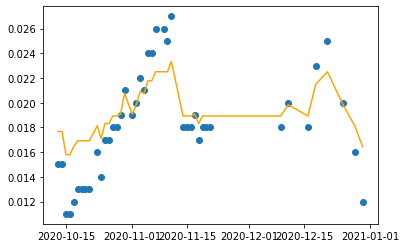

In [462]:
plt.scatter(Malawi.index[-y_true.size:], y_true)
plt.plot(Malawi.index[-y_true.size:], y_pred, color='orange')

### Note

## References

    [1]  Hasell, J., Mathieu, E., Beltekian, D. et al. A cross-country database of COVID-19 testing. Sci Data 7, 345 (2020)
    [2]  Hannah Ritchie (2019) - "Age Structure". Published online at OurWorldInData.org. Retrieved from: 'https://ourworldindata.org/age-structure' [Online Resource]
    [3] UN. (2017). Changing population age structures and sustainable development. Department of Economic and Social Affairs, ST/ESA/SER(E/CN.9/2017/2), 33.
    [4] https://towardsdatascience.com/time-series-analysis-using-pandas-in-python-f726d87a97d8
    [5] https://towardsdatascience.com/time-series-modeling-using-scikit-pandas-and-numpy-682e3b8db8d1